In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import ast
from collections import Counter
from ast import literal_eval
from itertools import chain


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
RED = '#E38E39'
BLUE = '#1F509A'
LBLUE = '#d4ebf8'
# pd.set_option('display.max_rows', None)

In [3]:
df = pd.read_csv("rawg_games_1000.csv")
df.head()

,name,description_raw,metacritic,playtime,tags,stores,esrb_rating,developers,publishers,updated,added_by_status
0,Grand Theft Auto V,"Rockstar Games went bigger, since their previo...",92.0,74,"['Singleplayer', 'Steam Achievements', 'Multip...","['Steam', 'PlayStation Store', 'Epic Games', '...",Mature,"['Rockstar North', 'Rockstar Games']",['Rockstar Games'],2025-05-26T14:58:48,"{'yet': 557, 'owned': 12702, 'beaten': 6240, '..."
1,The Witcher 3: Wild Hunt,"The third game in a series, it holds nothing b...",92.0,43,"['Singleplayer', 'Full controller support', 'A...","['GOG', 'PlayStation Store', 'Steam', 'Xbox St...",Mature,['CD PROJEKT RED'],['CD PROJEKT RED'],2025-05-25T18:05:53,"{'yet': 1173, 'owned': 12701, 'beaten': 5083, ..."
2,Portal 2,Portal 2 is a first-person puzzle game develop...,95.0,11,"['Singleplayer', 'Steam Achievements', 'Multip...","['Xbox Store', 'Steam', 'PlayStation Store', '...",Everyone 10+,['Valve Software'],"['Electronic Arts', 'Valve']",2025-05-26T14:58:22,"{'yet': 657, 'owned': 13004, 'beaten': 5711, '..."
3,Counter-Strike: Global Offensive,Counter-Strike is a multiplayer phenomenon in ...,81.0,64,"['Steam Achievements', 'Multiplayer', 'Full co...","['PlayStation Store', 'Steam', 'Xbox 360 Store']",Mature,"['Valve Software', 'Hidden Path Entertainment']",['Valve'],2025-05-26T16:11:35,"{'yet': 268, 'owned': 14083, 'beaten': 1105, '..."
4,Tomb Raider (2013),A cinematic revival of the series in its actio...,86.0,10,"['Singleplayer', 'Multiplayer', 'Full controll...","['Xbox 360 Store', 'Steam', 'PlayStation Store...",Mature,['Crystal Dynamics'],['Square Enix'],2025-05-23T20:02:39,"{'yet': 695, 'owned': 11542, 'beaten': 4393, '..."


## Basic EDA and Descriptive Statistics

- metacritic: ?/100
- tag, stores, developers, publishers: list type
- esrb_rating: Mature, Teen, Everyone 10+, Everyone, Adults Only, Rating Pending
- added_by_status: data dạng key value -> tạo thành nhiều feature khác nhau từ cột này 

      - yet: Người dùng đã thêm game vào danh sách nhưng chưa bắt đầu chơi.
      - owned: Người dùng đã sở hữu trò chơi này
      - beaten: Người dùng đã phá đảo
      - toplay: xuất hiện trong wishlist của bao nhiêu người dùng 
      - dropped: Người dùng đã bỏ chơi trò chơi này trước khi phá đảo 
      - playing: Người dùng hiện đang chơi trò chơi này
      

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1034 entries, 0 to 1033
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             1034 non-null   object 
 1   description_raw  1032 non-null   object 
 2   metacritic       900 non-null    float64
 3   playtime         1034 non-null   int64  
 4   tags             1034 non-null   object 
 5   stores           1034 non-null   object 
 6   esrb_rating      758 non-null    object 
 7   developers       1034 non-null   object 
 8   publishers       1034 non-null   object 
 9   updated          1034 non-null   object 
 10  added_by_status  1034 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 89.0+ KB


**Features in RAWG**

|Name       | Meaning                                                                 |
|----------------------|-------------------------------------------------------------------------|
| `description_raw`    | Mô tả game                                             |
| `metacritic`         | Điểm đánh giá trung bình từ Metacritic                                 |
| `playtime`           | Thời lượng chơi trung bình của người chơi (tính theo giờ)              |
| `tags`               | Các thẻ mô tả đặc trưng của game (ví dụ: `"Multiplayer"`, `"Open World"`) |
| `stores`             | Danh sách nền tảng mà game được phân phối (ví dụ: Steam, Epic Games...) |
| `esrb_rating`        | Độ tuổi phù hợp (ví dụ: E - Everyone, T - Teen, M - Mature...)          |
| `developers`         | Tên nhà phát triển game                                                 |
| `publishers`         | Tên nhà phát hành game                                                  |
| `updated`            | Ngày cập nhật dữ liệu gần nhất từ API                                  |
| `added_by_status`    | Thống kê số lượng người dùng thêm game vào backlog/wishlist/played/... |



In [5]:
def check_data(dataframe):
    # Check shape
    print(f"Shape: {dataframe.shape}\n")
    print('-' * 50)
    # Check for duplicates
    print(f"Duplicates: {dataframe.duplicated().sum()}\n")
    print('-' * 50)
    # Check for missing values
    print('Missing value')
    df_temp = dataframe.isnull().sum().reset_index()
    df_temp['% missing'] = df_temp.iloc[:, 1] / len(dataframe) * 100
    print(df_temp)
    print('-' * 50)
    # Describe numeric columns
    if not dataframe.select_dtypes(exclude='object').empty:
        print("Descriptive Statistics for Numeric Columns:\n", dataframe.describe(include=[float, int]), "\n")
        print('-' * 50)
    # Describ   print('-' * 50)e object (categorical) columns
    if not dataframe.select_dtypes(include='object').empty:
        print("Descriptive Statistics for Categorical Columns:\n", dataframe.describe(include=[object]), "\n")
        print('-' * 50)
    # Check data types
    print("Data Types:\n", dataframe.dtypes, "\n")
    print('-' * 50)
    # Check unique values for each column
    unique_counts = dataframe.nunique()
    print("Unique Values Count:\n", unique_counts, "\n")
    print('-' * 50)
    # Values count
    for col in dataframe.columns:
        print(dataframe[col].value_counts().head())
        print('-' * 30)

In [6]:
check_data(df)

Shape: (1034, 11)

--------------------------------------------------
Duplicates: 0

--------------------------------------------------
Missing value
              index    0  % missing
0              name    0   0.000000
1   description_raw    2   0.193424
2        metacritic  134  12.959381
3          playtime    0   0.000000
4              tags    0   0.000000
5            stores    0   0.000000
6       esrb_rating  276  26.692456
7        developers    0   0.000000
8        publishers    0   0.000000
9           updated    0   0.000000
10  added_by_status    0   0.000000
--------------------------------------------------
Descriptive Statistics for Numeric Columns:
        metacritic     playtime
count  900.000000  1034.000000
mean    80.034444     6.216634
std      8.097702     8.279219
min     44.000000     0.000000
25%     75.000000     2.000000
50%     81.000000     4.000000
75%     86.000000     7.000000
max     97.000000   121.000000 

-----------------------------------------

In [7]:
df.describe()

,metacritic,playtime
count,900.000000,1034.000000
mean,80.034444,6.216634
std,8.097702,8.279219
min,44.000000,0.000000
25%,75.000000,2.000000
50%,81.000000,4.000000
75%,86.000000,7.000000
max,97.000000,121.000000


In [8]:
print("Min:", df['updated'].min())
print("Max:", df['updated'].max())

Min: 2023-12-18T17:49:15
Max: 2025-05-27T05:14:51


In [9]:
df[df['playtime'] == 0]

,name,description_raw,metacritic,playtime,tags,stores,esrb_rating,developers,publishers,updated,added_by_status
87,Uncharted 4: A Thief’s End,Uncharted 4 is the final installment in the Un...,93.0,0,"['Atmospheric', 'Action-Adventure', '3rd-Perso...",['PlayStation Store'],Teen,['Naughty Dog'],['Sony Computer Entertainment'],2025-05-26T16:17:00,"{'yet': 410, 'owned': 4805, 'beaten': 3316, 't..."
196,The Last of Us Part II,The Last of Us Part II is the sequel to the po...,93.0,0,"['Singleplayer', 'Atmospheric', 'Survival', 'V...",['PlayStation Store'],Mature,['Naughty Dog'],['Sony Interactive Entertainment'],2025-05-25T20:22:20,"{'yet': 406, 'owned': 3294, 'beaten': 1834, 't..."
292,inFAMOUS Second Son,Action adventure game inFAMOUS: Second Son is ...,80.0,0,"['exclusive', 'true exclusive']",['PlayStation Store'],Teen,['Sucker Punch Productions'],['Sony Computer Entertainment'],2025-05-23T22:24:56,"{'yet': 213, 'owned': 3776, 'beaten': 1511, 't..."
305,Ghost of Tsushima,The year is 1274. Samurai warriors are the leg...,83.0,0,"['Singleplayer', 'Atmospheric', 'RPG', 'Open W...","['Steam', 'PlayStation Store']",Mature,['Sucker Punch Productions'],['Sony Interactive Entertainment'],2025-05-26T15:55:17,"{'yet': 383, 'owned': 3017, 'beaten': 956, 'to..."
367,Fortnite Battle Royale,Fortnite Battle Royale is the completely free ...,NaN,0,"['Multiplayer', 'Sci-fi', 'Sandbox', 'Comedy',...","['PlayStation Store', 'Xbox Store', 'App Store...",Teen,['Epic Games'],['Epic Games Publishing'],2025-05-07T18:00:41,"{'yet': 48, 'owned': 3804, 'beaten': 226, 'top..."
379,Final Fantasy VII,"The world is under the control of Shinra, a co...",87.0,0,"['Singleplayer', 'Atmospheric', 'RPG', 'Story ...","['Steam', 'PlayStation Store', 'Epic Games']",Teen,['Square Enix'],['Square Enix'],2025-05-21T14:06:56,"{'yet': 363, 'owned': 2942, 'beaten': 764, 'to..."
382,The Playroom,The Playroom is a collection of augmented real...,NaN,0,"['exclusive', 'true exclusive']",['PlayStation Store'],Everyone 10+,"['SCE Japan Studio', 'Sony Interactive Enterta...",[],2025-01-03T07:43:20,"{'yet': 202, 'owned': 4489, 'beaten': 144, 'to..."
525,Uncharted: The Lost Legacy,The first installment in the Uncharted series ...,85.0,0,"['Atmospheric', 'Story Rich', 'Third Person', ...",['PlayStation Store'],Teen,['Naughty Dog'],['Sony Computer Entertainment'],2025-05-18T21:40:25,"{'yet': 240, 'owned': 1982, 'beaten': 1274, 't..."
551,Genshin Impact,You have arrived in Teyvat — a fantasy world w...,83.0,0,"['Singleplayer', 'Multiplayer', 'Great Soundtr...","['PlayStation Store', 'App Store', 'Google Pla...",Teen,['miHoYo'],['miHoYo'],2025-05-20T03:36:31,"{'yet': 143, 'owned': 2148, 'beaten': 186, 'to..."
590,Super Mario Odyssey,"Super Mario Odyssey is a 3D platform game, a p...",97.0,0,"['Singleplayer', 'Local Multiplayer', 'Family ...",['Nintendo Store'],Everyone 10+,['Nintendo'],['Nintendo'],2025-05-26T05:15:47,"{'yet': 198, 'owned': 760, 'beaten': 1864, 'to..."


In [10]:
df = df.drop(df[df['playtime'] == 0].index)

Lỗi logic: người chơi phải own game đó, thì mới có thể beat game đó, mới có thể drop game đó, mới có thể playing game. Vì vậy, status_own > (beaten, drop, playing)

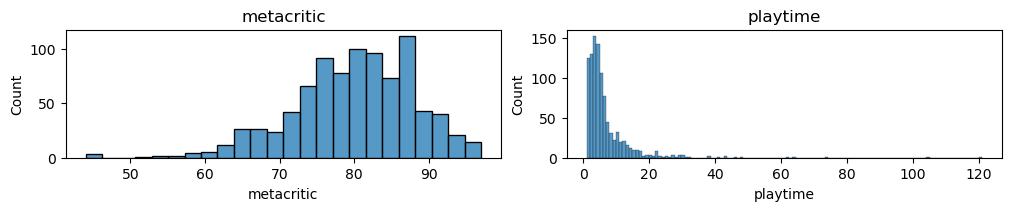

In [11]:
cols_to_plot = df.select_dtypes('number').columns.tolist()
ncol, nrow = 2, len(cols_to_plot)//3 + 1 # customerize the number of columns and rows

fig , axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(10, len(cols_to_plot)), constrained_layout=True)

for ax, column in zip(axes.flatten(), cols_to_plot): 
    sns.histplot(df[column], ax=ax)
    ax.set_title(column)

plt.show()

In [12]:
df1 = df.copy(deep=True)
df1["added_by_status"] = df1["added_by_status"].apply(ast.literal_eval)
for key in ["yet", "owned", "beaten", "toplay", "dropped", "playing"]:
    #df1[key] = df1["added_by_status"].apply(lambda x: x.get(key, 0))
      df1['status_'+ key] = df1["added_by_status"].apply(lambda x: x.get(key, 0))
df1.drop(columns=["added_by_status"], inplace=True)
df1.head()

,name,description_raw,metacritic,playtime,tags,stores,esrb_rating,developers,publishers,updated,status_yet,status_owned,status_beaten,status_toplay,status_dropped,status_playing
0,Grand Theft Auto V,"Rockstar Games went bigger, since their previo...",92.0,74,"['Singleplayer', 'Steam Achievements', 'Multip...","['Steam', 'PlayStation Store', 'Epic Games', '...",Mature,"['Rockstar North', 'Rockstar Games']",['Rockstar Games'],2025-05-26T14:58:48,557,12702,6240,626,1154,752
1,The Witcher 3: Wild Hunt,"The third game in a series, it holds nothing b...",92.0,43,"['Singleplayer', 'Full controller support', 'A...","['GOG', 'PlayStation Store', 'Steam', 'Xbox St...",Mature,['CD PROJEKT RED'],['CD PROJEKT RED'],2025-05-25T18:05:53,1173,12701,5083,833,991,892
2,Portal 2,Portal 2 is a first-person puzzle game develop...,95.0,11,"['Singleplayer', 'Steam Achievements', 'Multip...","['Xbox Store', 'Steam', 'PlayStation Store', '...",Everyone 10+,['Valve Software'],"['Electronic Arts', 'Valve']",2025-05-26T14:58:22,657,13004,5711,397,626,161
3,Counter-Strike: Global Offensive,Counter-Strike is a multiplayer phenomenon in ...,81.0,64,"['Steam Achievements', 'Multiplayer', 'Full co...","['PlayStation Store', 'Steam', 'Xbox 360 Store']",Mature,"['Valve Software', 'Hidden Path Entertainment']",['Valve'],2025-05-26T16:11:35,268,14083,1105,79,2094,631
4,Tomb Raider (2013),A cinematic revival of the series in its actio...,86.0,10,"['Singleplayer', 'Multiplayer', 'Full controll...","['Xbox 360 Store', 'Steam', 'PlayStation Store...",Mature,['Crystal Dynamics'],['Square Enix'],2025-05-23T20:02:39,695,11542,4393,285,557,117


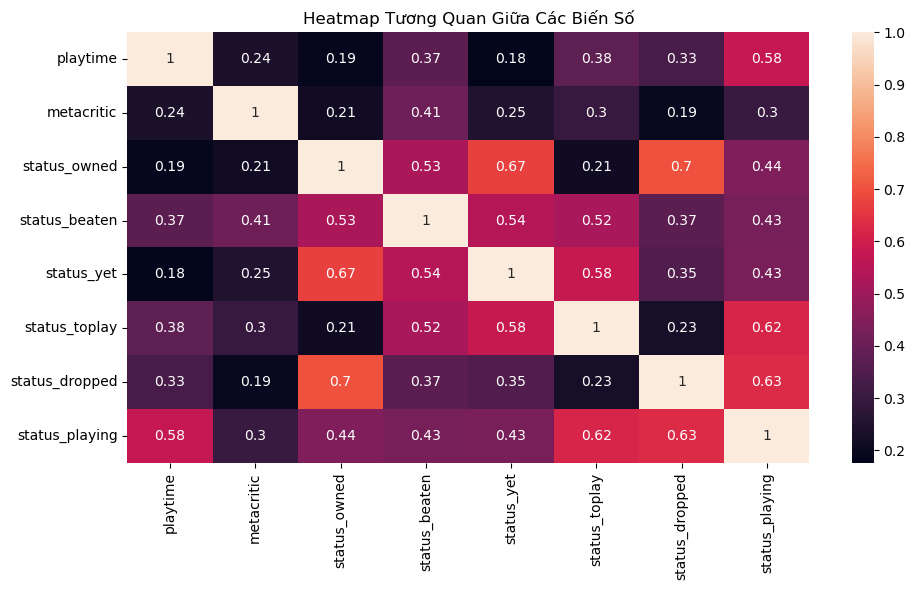

In [13]:
corr = df1[["playtime", "metacritic", "status_owned", "status_beaten", "status_yet", "status_toplay", "status_dropped", "status_playing"]].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True)
plt.title("Heatmap Tương Quan Giữa Các Biến Số")
plt.tight_layout()
plt.show()


Những records này đều có người hơi beaten và playing >0 tuy nhiên playtime laị bằng 0, điều này trái với logic, tôi sẽ lọại bỏ những records này

In [14]:
df1[
      (df1['status_owned'] < df1['status_beaten']) |
      (df1['status_owned'] < df1['status_dropped']) |
      (df1['status_owned'] < df1['status_playing'])
]
df1 = df1.drop(
      df1[
      (df1['status_owned'] < df1['status_beaten']) |
      (df1['status_owned'] < df1['status_dropped']) |
      (df1['status_owned'] < df1['status_playing'])
].index
)


## Advanced Analysis
### 1. Tìm hiểu thị hiếu người chơi:
#### 1.1 Phân tích tag 



In [15]:
def plot_top_list(data_series, column_name="tags", top_k=50, normalize=False, title=None):
    """
    Vẽ barplot cho top_k giá trị phổ biến nhất trong cột dạng list (hoặc chuỗi biểu diễn list).

    Parameters:
    - data_series: pd.Series chứa list hoặc chuỗi biểu diễn list
    - column_name: tên cột (dùng cho tiêu đề và nhãn)
    - top_k: số lượng giá trị top cần vẽ
    - normalize: True để hiển thị phần trăm thay vì số đếm
    - title: tiêu đề biểu đồ (nếu không có sẽ tạo tự động)
    """
    data_series = data_series.dropna()
    top_tags = []
    # Nếu phần tử là list -> giữ nguyên; nếu là chuỗi -> parse
    if isinstance(data_series.iloc[0], list):
        parsed = data_series
    else:
        parsed = data_series.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    all_items = list(chain.from_iterable(parsed))

    counter = Counter(all_items)

    if normalize:
        total = sum(counter.values())
        top_items = [(k, round(v / total * 100, 2)) for k, v in counter.most_common(top_k)]
        value_col = "Percentage (%)"
    else:
        top_items = counter.most_common(top_k)
        value_col = "Count"

    df_top = pd.DataFrame(top_items, columns=[column_name.capitalize(), value_col])
    # top_tags.append(df_top[''])
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data=df_top, x=value_col, y=column_name.capitalize(), palette="Blues_d")
    plt.title(title or f"Top {top_k} {column_name.capitalize()} phổ biến nhất")
    plt.tight_layout()

    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f' if normalize else '%d', label_type='edge', fontsize=9, padding=3)

    plt.show()
    

/var/folders/87/r431hq3n75l_7nlczx7tq_9c0000gn/T/ipykernel_7459/3839405253.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_top, x=value_col, y=column_name.capitalize(), palette="Blues_d")


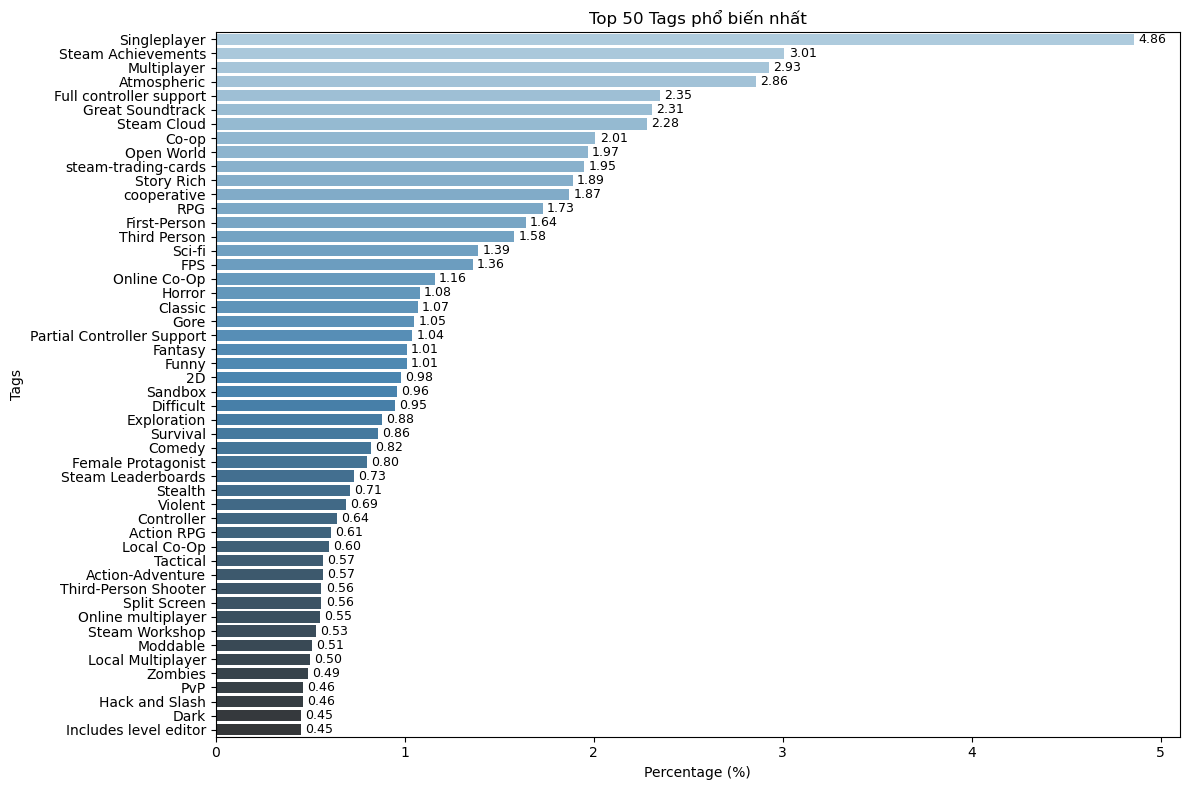

In [16]:

plot_top_list(df["tags"], column_name="tags", normalize=True, title="Top 50 Tags phổ biến nhất")


Trên đây là top 20 những tags xuất hiện nhiều nhất trong dataset tính theo % trên tổng số các tags có. Phần lớn tựa game đều được gắn nhiều tags, cho nên để phân tích và biểu đồ chính xác hơn, tôi đã tách các tags thành nhiều từ khoá đơn lẻ

Phân tích các features sau theo  top 50 tags
- numerical: metacritic, playtime
- categorical: esrb_rating


In [17]:
# Tạo DataFrame explode từ 'tags'
df_tags = df.copy()
df_tags['tags'] = df_tags['tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_tags = df_tags.explode('tags')

# Lấy Top 50 tags phổ biến
top_50_tags = df_tags['tags'].value_counts().nlargest(50).index.tolist()
df_top_tags = df_tags[df_tags['tags'].isin(top_50_tags)]


In [18]:
# Danh sách các cột sẽ explode
exploded_features = ['stores', 'developers', 'publishers']

# Chuyển từ chuỗi sang list nếu cần
for feature in exploded_features:
    if feature in df_top_tags.columns:
      df_top_tags[feature] = df_top_tags[feature].apply(
            lambda x: literal_eval(x) if isinstance(x, str) else x
        )

# Tạo bản sao và explode từng cột
top_tags_ep = df_top_tags.copy()
for feature in exploded_features:
    if feature in top_tags_ep.columns:
        top_tags_ep = top_tags_ep.explode(feature)


/var/folders/87/r431hq3n75l_7nlczx7tq_9c0000gn/T/ipykernel_7459/3226561444.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_tags[feature] = df_top_tags[feature].apply(


In [19]:
top_tags_ep.head()

,name,description_raw,metacritic,playtime,tags,stores,esrb_rating,developers,publishers,updated,added_by_status
0,Grand Theft Auto V,"Rockstar Games went bigger, since their previo...",92.0,74,Singleplayer,Steam,Mature,Rockstar North,Rockstar Games,2025-05-26T14:58:48,"{'yet': 557, 'owned': 12702, 'beaten': 6240, '..."
0,Grand Theft Auto V,"Rockstar Games went bigger, since their previo...",92.0,74,Singleplayer,Steam,Mature,Rockstar Games,Rockstar Games,2025-05-26T14:58:48,"{'yet': 557, 'owned': 12702, 'beaten': 6240, '..."
0,Grand Theft Auto V,"Rockstar Games went bigger, since their previo...",92.0,74,Singleplayer,PlayStation Store,Mature,Rockstar North,Rockstar Games,2025-05-26T14:58:48,"{'yet': 557, 'owned': 12702, 'beaten': 6240, '..."
0,Grand Theft Auto V,"Rockstar Games went bigger, since their previo...",92.0,74,Singleplayer,PlayStation Store,Mature,Rockstar Games,Rockstar Games,2025-05-26T14:58:48,"{'yet': 557, 'owned': 12702, 'beaten': 6240, '..."
0,Grand Theft Auto V,"Rockstar Games went bigger, since their previo...",92.0,74,Singleplayer,Epic Games,Mature,Rockstar North,Rockstar Games,2025-05-26T14:58:48,"{'yet': 557, 'owned': 12702, 'beaten': 6240, '..."


In [20]:
# Tính toán trung bình và số lượng một lần duy nhất
tag_stats = top_tags_ep.groupby('tags').agg(
    avg_metacritic=('metacritic', 'mean'),
    avg_playtime=('playtime', 'mean'),
    nbr_of_games=('tags', 'count'),
    age_tag = ('esrb_rating', lambda x: x.mode()[0] if not x.mode().empty else np.nan)  # Lấy mode của esrb_rating
).reset_index()

/var/folders/87/r431hq3n75l_7nlczx7tq_9c0000gn/T/ipykernel_7459/4141178430.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(sorted_tag_stats["tags"], rotation=45, ha='right')


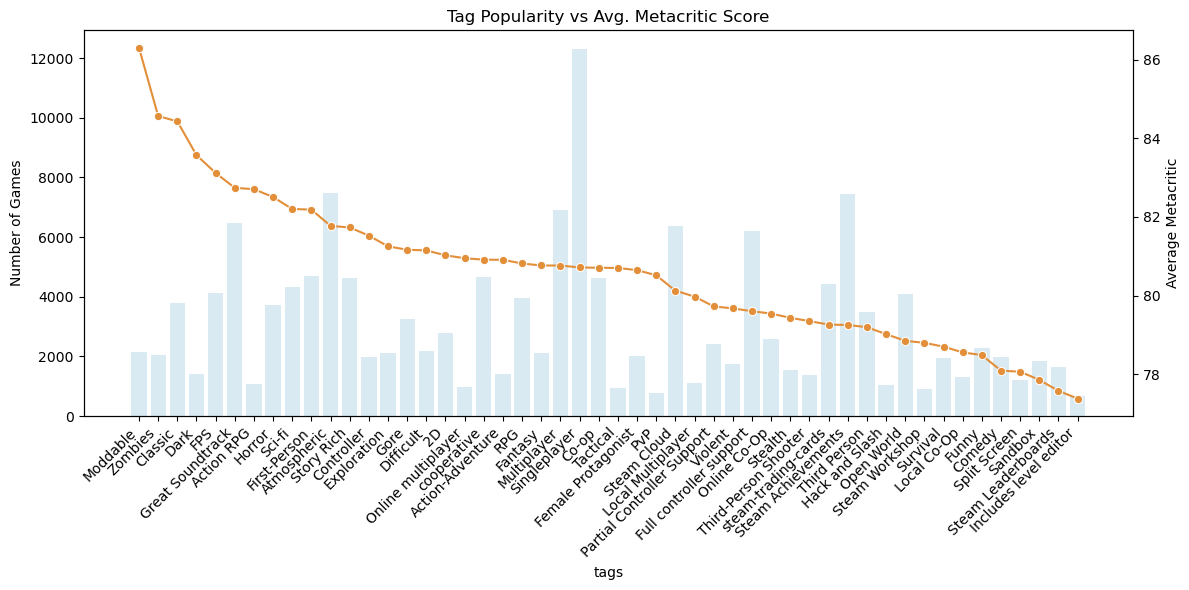

In [21]:

sorted_tag_stats = tag_stats.sort_values("avg_metacritic", ascending=False).head(50)

# Vẽ biểu đồ
fig, ax1 = plt.subplots(figsize=(12, 6))

# Barplot: số lượng game theo tag
sns.barplot(data=sorted_tag_stats, x="tags", y="nbr_of_games", ax=ax1, color=LBLUE)
ax1.set_ylabel("Number of Games")
ax1.set_xticklabels(sorted_tag_stats["tags"], rotation=45, ha='right')

# Lineplot: điểm trung bình Metacritic
ax2 = ax1.twinx()
sns.lineplot(data=sorted_tag_stats, x="tags", y="avg_metacritic", ax=ax2, color=RED, marker="o")
ax2.set_ylabel("Average Metacritic")

plt.title("Tag Popularity vs Avg. Metacritic Score")
plt.tight_layout()
plt.show()


##### Phân Tích Mối Quan Hệ Giữa Độ Phổ Biến Tag Và Điểm Metacritic Trung Bình


**Mô tả biểu đồ:**

- Trục trái (cột xanh nhạt): Số lượng game có chứa mỗi tag → thể hiện **độ phổ biến** của tag.
- Trục phải (đường nét liền, cam): Điểm Metacritic trung bình cho các game chứa tag đó → thể hiện **chất lượng trung bình** của game có tag tương ứng.

**Nhận định chính:**
- **Singleplayer**, **Story Rich**, **Steam Achievements**, **Atmospheric** và **Great Soundtrack** là các tag phổ biến nhất, với hàng ngàn game gắn thẻ.
- Tuy nhiên, độ phổ biến không đảm bảo chất lượng game, ơ đây được đánh giá bằng điểm Metacritic.


/var/folders/87/r431hq3n75l_7nlczx7tq_9c0000gn/T/ipykernel_7459/881459336.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(sorted_tag_stats["tags"], rotation=45, ha='right')


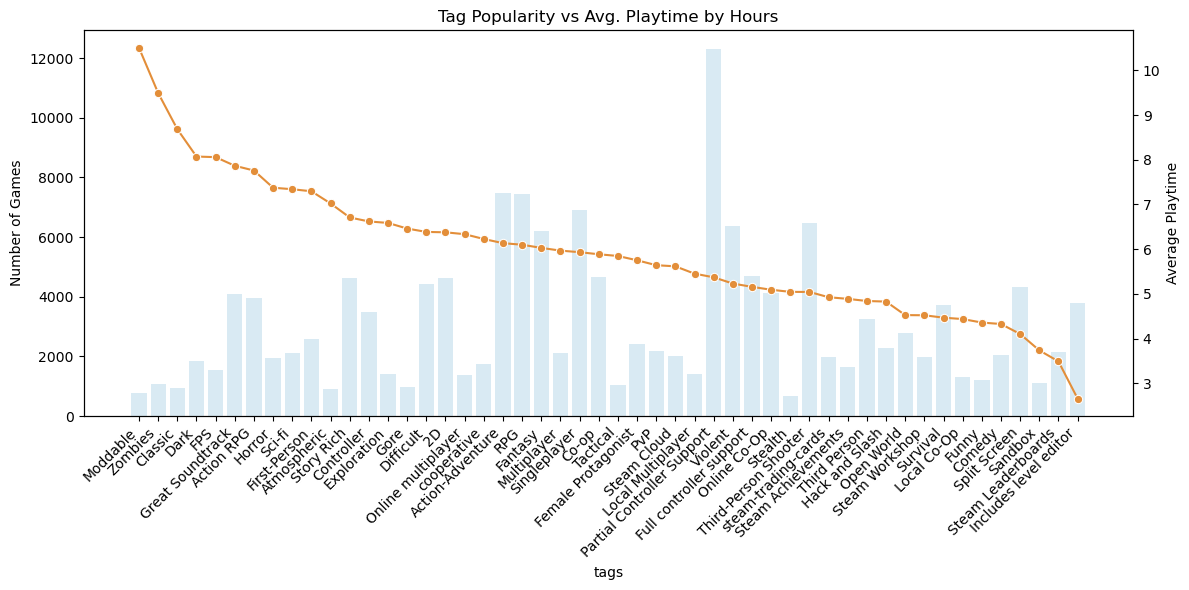

In [22]:
# Sắp xếp theo avg_playtime để hiển thị đẹp
sorted_tag_stats2 = tag_stats.sort_values("avg_playtime", ascending=False).head(50)

# Vẽ biểu đồ
fig, ax1 = plt.subplots(figsize=(12, 6))

# Barplot: số lượng game theo tag
sns.barplot(data=sorted_tag_stats2, x="tags", y="nbr_of_games", ax=ax1, color=LBLUE)
ax1.set_ylabel("Number of Games")
ax1.set_xticklabels(sorted_tag_stats["tags"], rotation=45, ha='right')

# Lineplot: tb playtime
ax2 = ax1.twinx()
sns.lineplot(data=sorted_tag_stats, x="tags", y="avg_playtime", ax=ax2, color=RED, marker="o")
ax2.set_ylabel("Average Playtime")

plt.title("Tag Popularity vs Avg. Playtime by Hours")
plt.tight_layout()
plt.show()

##### Phân Tích Mối Quan Hệ Giữa Độ Phổ Biến Tag Và Thời Gian Chơi Trung Bình

**Mô tả biểu đồ:**

- Trục trái (cột xanh nhạt): Số lượng game có gắn tag tương ứng (mức độ phổ biến).
- Trục phải (đường nét liền màu cam): Thời gian chơi trung bình (giờ) cho các game có tag đó.

**Nhận định chính:**

- Các tag có playtime trong top đầu như : **Moddable**, **Zombies**, **Classic**, **2D**, **Great Soundtrack** lại không thực sự phổ biến. Trong khi đó, một số  Tag có thời gian chơi trung bình thấp như **Includes Level Editor**, **Split Screen**, **Funny**, **Local Co-op** có thời gian chơi trung bình thấp nhất (~3–4h).
Điều này dễ giải thích, có thể là các trò chơi phụ trợ, casual, hoặc trải nghiệm ngắn, cũng có thể xuất phát từ sự yêu cầu cooperate khi chơi.


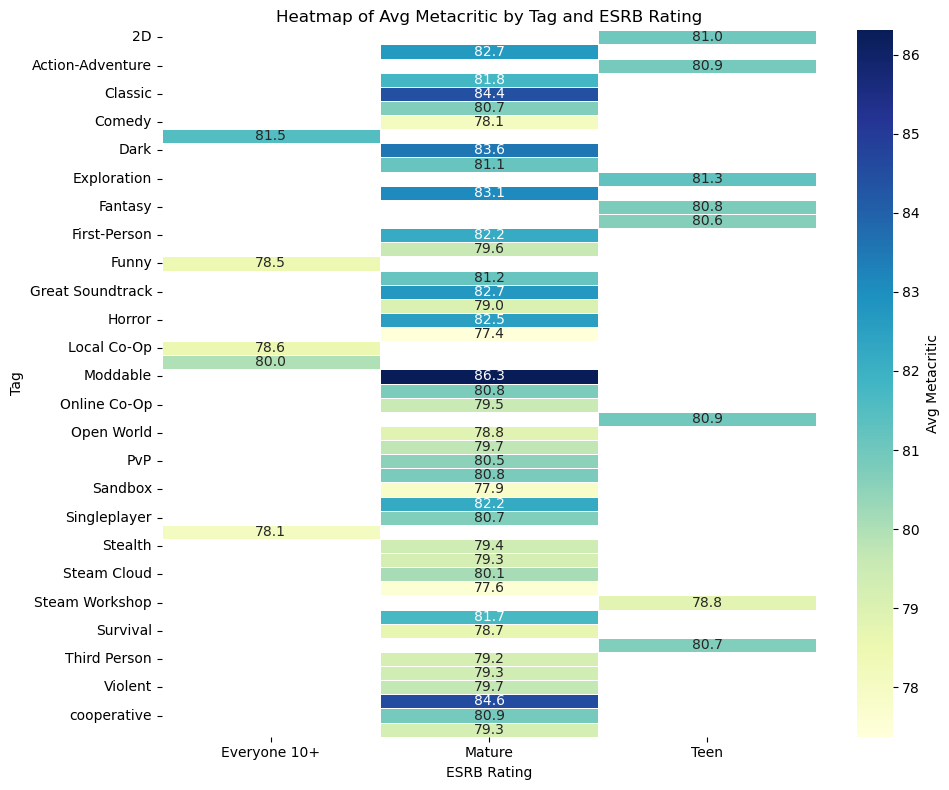

In [23]:
# Tạo bảng pivot với tag là index, age_tag là cột, và giá trị là avg_metacritic
heatmap_data = tag_stats.pivot_table(index='tags', columns='age_tag', values='avg_metacritic')

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5, cbar_kws={'label': 'Avg Metacritic'})
plt.title("Heatmap of Avg Metacritic by Tag and ESRB Rating")
plt.xlabel("ESRB Rating")
plt.ylabel("Tag")
plt.tight_layout()
plt.show()



Phân Tích Điểm Đánh Giá Metacritic Trung Bình Theo Tag và ESRB Rating
Phần lớn những tags hay xuất hiện đều được dán nhãn dành cho người trưởng thành (mature)

Điểm cao nổi bật:
- **Moddable - Mature**: 86.3 
- **Classic - Everyone 10+**: 84.4
- **Cooperative - Mature**: 84.0
- **Fantasy - Everyone 10+**: 83.1
- **Dark - Everyone 10+**: 85.6
- Các tag như **Action-Adventure**, **Exploration**, **Great Soundtrack**, **First-Person** đều có điểm Metacritic trung bình cao (trên 82) trong nhóm **Mature**.

Điểm thấp hơn:
- Một số tag có điểm trung bình dưới 79:
  - **Funny - Everyone 10+**: 78.5
  - **Sandbox - Mature**: 77.9
  - **Local Co-op - Mature**: 77.4
  - **Steam Workshop - Mature**: 77.6

ESRB rating có ảnh hưởng:
- **Mature** rating chiếm đa số dữ liệu và thể hiện điểm đánh giá ổn định quanh mức 80–83. Các tựa game cho **Everyone 10+** có điểm khá cao ở một số tag (Classic, Fantasy), cho thấy không phải lúc nào game được dán nhãn dành cho người  trưởng thành cũng được đánh giá cao hơn.
- **Teen** rating ít xuất hiện hơn, nhưng những điểm hiện có vẫn ở mức khá (78–81).



#### 1.2 Phân tích status và playtime

##### Phân tích Tags, ESRB Rating, Metacritic distribution của top 100 những game được sở hữu (own), được thêm vào wishlist (toplay) và những game hay bị drop nhất (theo %)

In [24]:
df1.head()

,name,description_raw,metacritic,playtime,tags,stores,esrb_rating,developers,publishers,updated,status_yet,status_owned,status_beaten,status_toplay,status_dropped,status_playing
0,Grand Theft Auto V,"Rockstar Games went bigger, since their previo...",92.0,74,"['Singleplayer', 'Steam Achievements', 'Multip...","['Steam', 'PlayStation Store', 'Epic Games', '...",Mature,"['Rockstar North', 'Rockstar Games']",['Rockstar Games'],2025-05-26T14:58:48,557,12702,6240,626,1154,752
1,The Witcher 3: Wild Hunt,"The third game in a series, it holds nothing b...",92.0,43,"['Singleplayer', 'Full controller support', 'A...","['GOG', 'PlayStation Store', 'Steam', 'Xbox St...",Mature,['CD PROJEKT RED'],['CD PROJEKT RED'],2025-05-25T18:05:53,1173,12701,5083,833,991,892
2,Portal 2,Portal 2 is a first-person puzzle game develop...,95.0,11,"['Singleplayer', 'Steam Achievements', 'Multip...","['Xbox Store', 'Steam', 'PlayStation Store', '...",Everyone 10+,['Valve Software'],"['Electronic Arts', 'Valve']",2025-05-26T14:58:22,657,13004,5711,397,626,161
3,Counter-Strike: Global Offensive,Counter-Strike is a multiplayer phenomenon in ...,81.0,64,"['Steam Achievements', 'Multiplayer', 'Full co...","['PlayStation Store', 'Steam', 'Xbox 360 Store']",Mature,"['Valve Software', 'Hidden Path Entertainment']",['Valve'],2025-05-26T16:11:35,268,14083,1105,79,2094,631
4,Tomb Raider (2013),A cinematic revival of the series in its actio...,86.0,10,"['Singleplayer', 'Multiplayer', 'Full controll...","['Xbox 360 Store', 'Steam', 'PlayStation Store...",Mature,['Crystal Dynamics'],['Square Enix'],2025-05-23T20:02:39,695,11542,4393,285,557,117


Thêm các features tính tỉ lệ: tỉ lệ phá đảo game (completion_rate), tỉ lệ bỏ game giữa chừng (drop_rate), tỉ lệ game vẫn đang được chơi (play_rate) với logic như sau

In [25]:
# Tính tỷ lệ
df1["completion_rate"] = df1["status_beaten"] / df1["status_owned"]
df1["drop_rate"] = df1["status_dropped"] / df1["status_owned"]
df1["play_rate"] = df1["status_playing"] / df1["status_owned"]
df1.head()


,name,description_raw,metacritic,playtime,tags,stores,esrb_rating,developers,publishers,updated,status_yet,status_owned,status_beaten,status_toplay,status_dropped,status_playing,completion_rate,drop_rate,play_rate
0,Grand Theft Auto V,"Rockstar Games went bigger, since their previo...",92.0,74,"['Singleplayer', 'Steam Achievements', 'Multip...","['Steam', 'PlayStation Store', 'Epic Games', '...",Mature,"['Rockstar North', 'Rockstar Games']",['Rockstar Games'],2025-05-26T14:58:48,557,12702,6240,626,1154,752,0.491261,0.090852,0.059203
1,The Witcher 3: Wild Hunt,"The third game in a series, it holds nothing b...",92.0,43,"['Singleplayer', 'Full controller support', 'A...","['GOG', 'PlayStation Store', 'Steam', 'Xbox St...",Mature,['CD PROJEKT RED'],['CD PROJEKT RED'],2025-05-25T18:05:53,1173,12701,5083,833,991,892,0.400205,0.078025,0.070231
2,Portal 2,Portal 2 is a first-person puzzle game develop...,95.0,11,"['Singleplayer', 'Steam Achievements', 'Multip...","['Xbox Store', 'Steam', 'PlayStation Store', '...",Everyone 10+,['Valve Software'],"['Electronic Arts', 'Valve']",2025-05-26T14:58:22,657,13004,5711,397,626,161,0.439173,0.048139,0.012381
3,Counter-Strike: Global Offensive,Counter-Strike is a multiplayer phenomenon in ...,81.0,64,"['Steam Achievements', 'Multiplayer', 'Full co...","['PlayStation Store', 'Steam', 'Xbox 360 Store']",Mature,"['Valve Software', 'Hidden Path Entertainment']",['Valve'],2025-05-26T16:11:35,268,14083,1105,79,2094,631,0.078463,0.148690,0.044806
4,Tomb Raider (2013),A cinematic revival of the series in its actio...,86.0,10,"['Singleplayer', 'Multiplayer', 'Full controll...","['Xbox 360 Store', 'Steam', 'PlayStation Store...",Mature,['Crystal Dynamics'],['Square Enix'],2025-05-23T20:02:39,695,11542,4393,285,557,117,0.380610,0.048259,0.010137


In [26]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1003 entries, 0 to 1033
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             1003 non-null   object 
 1   description_raw  1001 non-null   object 
 2   metacritic       873 non-null    float64
 3   playtime         1003 non-null   int64  
 4   tags             1003 non-null   object 
 5   stores           1003 non-null   object 
 6   esrb_rating      728 non-null    object 
 7   developers       1003 non-null   object 
 8   publishers       1003 non-null   object 
 9   updated          1003 non-null   object 
 10  status_yet       1003 non-null   int64  
 11  status_owned     1003 non-null   int64  
 12  status_beaten    1003 non-null   int64  
 13  status_toplay    1003 non-null   int64  
 14  status_dropped   1003 non-null   int64  
 15  status_playing   1003 non-null   int64  
 16  completion_rate  1003 non-null   float64
 17  drop_rate        10

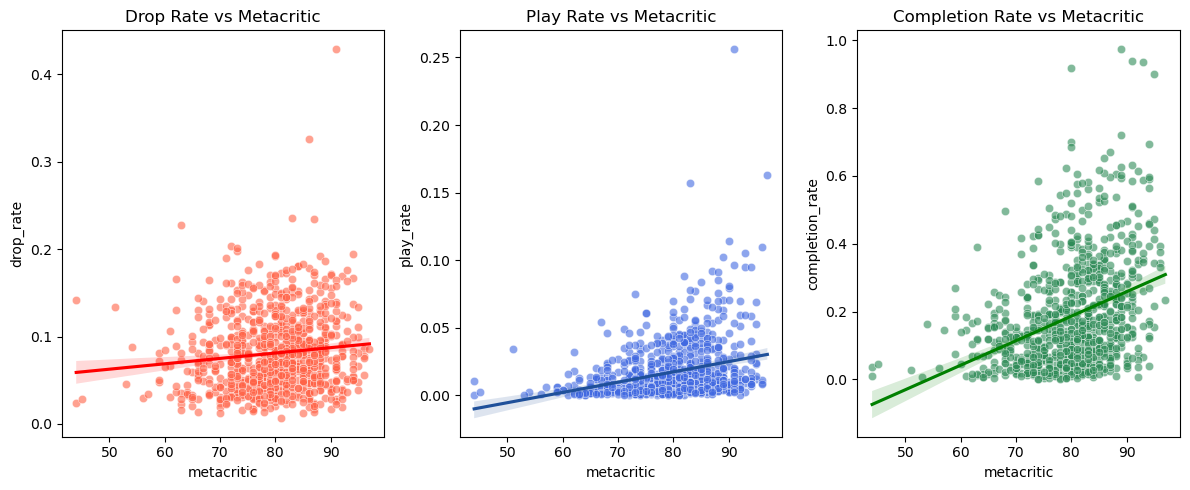

In [27]:
plt.figure(figsize=(12, 5))

# Drop Rate vs Metacritic
plt.subplot(1, 3, 1)
sns.scatterplot(data=df1, x="metacritic", y="drop_rate", alpha=0.6, color="tomato")
sns.regplot(data=df1, x="metacritic", y="drop_rate", scatter=False, color='red')
plt.title("Drop Rate vs Metacritic")

# Play Rate vs Metacritic
plt.subplot(1, 3, 2)
sns.scatterplot(data=df1, x="metacritic", y="play_rate", alpha=0.6, color="royalblue")
sns.regplot(data=df1, x="metacritic", y="play_rate", scatter=False, color=BLUE)
plt.title("Play Rate vs Metacritic")

# Completion Rate vs Metacritic (use green)
plt.subplot(1, 3, 3)
sns.scatterplot(data=df1, x="metacritic", y="completion_rate", alpha=0.6, color="seagreen")
sns.regplot(data=df1, x="metacritic", y="completion_rate", scatter=False, color="green")
plt.title("Completion Rate vs Metacritic")

plt.tight_layout()
plt.show()


In [28]:
correlation_drop = df1[['metacritic', 'drop_rate']].corr().iloc[0, 1]
correlation_play = df1[['metacritic', 'play_rate']].corr().iloc[0, 1]
correlation_complete = df1[['metacritic', 'completion_rate']].corr().iloc[0, 1]
print(f"Hệ số tương quan Pearson (Metacritic ↔ Drop Rate): {correlation_drop:.3f}")
print(f"Hệ số tương quan Pearson (Metacritic ↔ Play Rate): {correlation_play:.3f}")
print(f"Hệ số tương quan Pearson (Metacritic ↔ Completion Rate): {correlation_complete:.3f}")



Hệ số tương quan Pearson (Metacritic ↔ Drop Rate): 0.113
Hệ số tương quan Pearson (Metacritic ↔ Play Rate): 0.289
Hệ số tương quan Pearson (Metacritic ↔ Completion Rate): 0.364


- Metacritic có mối liên hệ dương nhẹ với completion rate và play rate, nghĩa là:
Game có điểm đánh giá Metacritic cao có xu hướng được nhiều người chơi hơn và được hoàn thành nhiều hơn.

- Tuy nhiên, mối liên hệ không mạnh, cho thấy Metacritic chỉ là một yếu tố trong nhiều yếu tố ảnh hưởng đến hành vi người chơi.Tương quan giữa Metacritic và Drop Rate gần như không đáng kể. Điều này có nghĩa là, việc người chơi từ bỏ game không phụ thuộc nhiều vào điểm Metacritic.

Tiếp theo, tôi sẽ extract top 100 game có drop rate, completion rate, toplay (game được thêm vào wishlist) cao nhất để phân tích kĩ tags, esrb rating của chúng

In [29]:
# Tính toán lại nếu chưa có
df1["completion_rate"] = df1["status_beaten"] / df1["status_owned"]
df1["drop_rate"] = df1["status_dropped"] / df1["status_owned"]
df1["play_rate"] = df1["status_playing"] / df1["status_owned"]
# # Top 50 theo completion_rate, drop_rate, toplay
# top_cp = df1.sort_values("completion_rate", ascending=False).head(50)
# top_dp = df1.sort_values("drop_rate", ascending=False).head(50)
# top_tp = df1.sort_values("status_toplay", ascending=False).head(50)


In [30]:
# drop nhieu 
top100_drop = df1.sort_values("drop_rate", ascending=False).head(100).reset_index(drop=True)
top100_drop.head()

,name,description_raw,metacritic,playtime,tags,stores,esrb_rating,developers,publishers,updated,status_yet,status_owned,status_beaten,status_toplay,status_dropped,status_playing,completion_rate,drop_rate,play_rate
0,Overwatch,###The Legacy\nOverwatch is a multiplayer firs...,91.0,41,"['Multiplayer', 'First-Person', 'Sci-fi', 'FPS...","['Nintendo Store', 'PlayStation Store', 'Xbox ...",Teen,[],"['Activision Blizzard', 'Blizzard Entertainment']",2025-05-22T20:45:30,45,1685,522,81,723,432,0.309792,0.429080,0.256380
1,The Sims 3,The Sims 3 is the third part of its series. Li...,86.0,11,"['Singleplayer', 'Multiplayer', 'Great Soundtr...","['Steam', 'Nintendo Store', 'Xbox 360 Store']",Teen,"['Electronic Arts', 'Edge of Reality', 'The Si...",['Electronic Arts'],2025-05-26T16:02:47,54,1452,600,26,474,36,0.413223,0.326446,0.024793
2,Minecraft,"One of the most popular games of the 2010s, Mi...",83.0,26,"['Multiplayer', 'Sandbox', '3D', 'Crafting', '...","['Nintendo Store', 'App Store', 'PlayStation S...",Everyone 10+,"['4J Studios', 'Mojang']","['Microsoft Studios', 'Mojang']",2025-05-23T20:02:31,79,4801,1782,116,1132,753,0.371173,0.235784,0.156842
3,Cuphead,Hand-drawn 2D platformer in the style of 30s c...,87.0,6,"['Singleplayer', 'Steam Achievements', 'Full c...","['PlayStation Store', 'GOG', 'Steam', 'Xbox St...",NaN,['Studio MDHR'],"['StudioMDHR Entertainment', 'Studio MDHR']",2025-05-22T01:22:48,438,4367,1099,650,1024,401,0.251660,0.234486,0.091825
4,Fallout Shelter,The game is a simulation of managing a refuge....,63.0,3,"['Singleplayer', 'Steam Achievements', 'Multip...","['Xbox Store', 'Steam', 'PlayStation Store', '...",Teen,"['Bethesda Softworks', 'Bethesda Game Studios']",['Bethesda Softworks'],2025-05-06T18:31:13,95,5108,594,20,1165,65,0.116288,0.228074,0.012725


In [31]:
# complete nhieu 
top100_cp = df1.sort_values('completion_rate', ascending=False).head(100).reset_index(drop=True)
top100_cp.head()

,name,description_raw,metacritic,playtime,tags,stores,esrb_rating,developers,publishers,updated,status_yet,status_owned,status_beaten,status_toplay,status_dropped,status_playing,completion_rate,drop_rate,play_rate
0,Assassin's Creed II,Assassin's Creed II is the second installment ...,89.0,14,"['Assassin', 'hero', 'Swords']","['Steam', 'Xbox Store', 'Xbox 360 Store']",Mature,['Ubisoft Montreal'],['Ubisoft Entertainment'],2025-05-23T18:05:43,224,3621,3529,173,382,50,0.974593,0.105496,0.013808
1,Batman: Arkham Asylum,Batman: Arkham Asylum as an action-adventure g...,91.0,13,"['Exploration', 'Stealth', 'puzzles', 'hero', ...","['Nintendo Store', 'App Store', 'PlayStation S...",Teen,['Rocksteady Studios'],"['Square Enix', 'Feral Interactive', 'Eidos In...",2025-05-26T12:34:46,290,2640,2479,200,268,54,0.939015,0.101515,0.020455
2,God of War II,The second installment in the God of War franc...,93.0,17,"['War', 'Story', 'console', 'Mythology', 'hist...",['PlayStation Store'],Mature,['SCE Studios Santa Monica'],"['Sony Computer Entertainment', 'ak tronic Sof...",2025-04-29T13:05:11,117,1177,1100,164,112,14,0.934579,0.095157,0.011895
3,Assassin's Creed Revelations,When a man has won all his battles and defeate...,80.0,14,"['Singleplayer', 'Multiplayer', 'Atmospheric',...","['PlayStation Store', 'Steam', 'Xbox Store', '...",Mature,['Ubisoft'],['Ubisoft Entertainment'],2025-05-24T18:45:05,223,2212,2032,139,186,25,0.918626,0.084087,0.011302
4,The Last Of Us,The population of the Earth almost disappeared...,95.0,15,['exclusive'],['PlayStation Store'],Mature,['Naughty Dog'],['Sony Computer Entertainment'],2025-05-25T20:25:28,277,3132,2823,509,207,76,0.901341,0.066092,0.024266


In [32]:
# Game được thêm vào wishlish nhiều nhất
top100_toplay = df1.sort_values("status_toplay", ascending=False).head(100).reset_index(drop=True)
top100_toplay.head()

,name,description_raw,metacritic,playtime,tags,stores,esrb_rating,developers,publishers,updated,status_yet,status_owned,status_beaten,status_toplay,status_dropped,status_playing,completion_rate,drop_rate,play_rate
0,Cyberpunk 2077,Cyberpunk 2077 is a science fiction game loose...,73.0,29,"['Singleplayer', 'Atmospheric', 'Great Soundtr...","['PlayStation Store', 'Xbox Store', 'Steam', '...",Mature,"['CD PROJEKT RED', 'CD PROJEKT']",['CD PROJEKT RED'],2025-05-25T20:15:59,855,6933,2332,2442,486,521,0.336362,0.070100,0.075148
1,Red Dead Redemption 2,"America, 1899. The end of the wild west era ha...",96.0,21,"['Singleplayer', 'Multiplayer', 'Atmospheric',...","['PlayStation Store', 'Epic Games', 'Steam', '...",Mature,['Rockstar Games'],['Rockstar Games'],2025-05-25T20:20:25,991,8626,3397,1647,739,948,0.393809,0.085671,0.109900
2,Death Stranding,Sam Bridges must brave a world utterly transfo...,84.0,11,"['Singleplayer', 'Atmospheric', 'Great Soundtr...","['Xbox Store', 'PlayStation Store', 'Epic Game...",Mature,['Kojima Productions'],"['Sony Interactive Entertainment', '505 Games']",2025-05-25T06:22:35,739,4699,1536,1386,490,362,0.326878,0.104278,0.077038
3,Sekiro: Shadows Die Twice,Sekiro: Shadows Die Twice is a game about a ni...,90.0,16,"['Singleplayer', 'Atmospheric', 'Great Soundtr...","['Xbox Store', 'Steam', 'PlayStation Store']",Mature,['FromSoftware'],"['Activison', 'FromSoftware', 'Activision Valu...",2025-05-26T02:48:30,555,3978,1385,1266,680,315,0.348165,0.170940,0.079186
4,God of War (2018),It is a new beginning for Kratos. Living as a ...,94.0,14,"['Singleplayer', 'Steam Achievements', 'Full c...","['GOG', 'PlayStation Store', 'Steam', 'Epic Ga...",Mature,['Santa Monica Studio'],"['Sony Interactive Entertainment', 'PlayStatio...",2025-05-26T14:58:13,707,7208,4248,1197,372,423,0.589345,0.051609,0.058685


In [33]:
top100_own = df1.sort_values("status_owned", ascending=False).head(100).reset_index(drop=True)
top100_own.head()

,name,description_raw,metacritic,playtime,tags,stores,esrb_rating,developers,publishers,updated,status_yet,status_owned,status_beaten,status_toplay,status_dropped,status_playing,completion_rate,drop_rate,play_rate
0,Counter-Strike: Global Offensive,Counter-Strike is a multiplayer phenomenon in ...,81.0,64,"['Steam Achievements', 'Multiplayer', 'Full co...","['PlayStation Store', 'Steam', 'Xbox 360 Store']",Mature,"['Valve Software', 'Hidden Path Entertainment']",['Valve'],2025-05-26T16:11:35,268,14083,1105,79,2094,631,0.078463,0.148690,0.044806
1,Portal 2,Portal 2 is a first-person puzzle game develop...,95.0,11,"['Singleplayer', 'Steam Achievements', 'Multip...","['Xbox Store', 'Steam', 'PlayStation Store', '...",Everyone 10+,['Valve Software'],"['Electronic Arts', 'Valve']",2025-05-26T14:58:22,657,13004,5711,397,626,161,0.439173,0.048139,0.012381
2,Left 4 Dead 2,Cooperative survival continues with a differen...,89.0,9,"['Singleplayer', 'Steam Achievements', 'Multip...","['Steam', 'Xbox 360 Store']",Mature,"['Valve Software', 'Turtle Rock Studios']","['Electronic Arts', 'Valve', 'Akella']",2025-05-24T15:23:14,394,12882,2602,117,1230,151,0.201987,0.095482,0.011722
3,Grand Theft Auto V,"Rockstar Games went bigger, since their previo...",92.0,74,"['Singleplayer', 'Steam Achievements', 'Multip...","['Steam', 'PlayStation Store', 'Epic Games', '...",Mature,"['Rockstar North', 'Rockstar Games']",['Rockstar Games'],2025-05-26T14:58:48,557,12702,6240,626,1154,752,0.491261,0.090852,0.059203
4,The Witcher 3: Wild Hunt,"The third game in a series, it holds nothing b...",92.0,43,"['Singleplayer', 'Full controller support', 'A...","['GOG', 'PlayStation Store', 'Steam', 'Xbox St...",Mature,['CD PROJEKT RED'],['CD PROJEKT RED'],2025-05-25T18:05:53,1173,12701,5083,833,991,892,0.400205,0.078025,0.070231


In [34]:
def analyze_top_games(df_top, title_prefix):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # === Top Tags (Percentage) ===
    tags = df_top["tags"].dropna().apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    all_tags = [tag for sublist in tags for tag in sublist]
    tag_counts = Counter(all_tags)
    total_tags = sum(tag_counts.values())
    tag_pct = [(tag, count / total_tags * 100) for tag, count in tag_counts.most_common(10)]
    tag_df = pd.DataFrame(tag_pct, columns=["Tag", "Percentage"])

    sns.barplot(data=tag_df, y="Tag", x="Percentage", ax=axes[0], palette="Blues_d")
    axes[0].set_title(f"{title_prefix}: Top Tags (%)")
    axes[0].set_xlabel("Percentage (%)")

    for p in axes[0].patches:
        axes[0].annotate(f"{p.get_width():.1f}%", 
                         (p.get_width(), p.get_y() + p.get_height() / 2),
                         va='center', ha='left', fontsize=9)

    # === ESRB Rating (Pie Chart) ===
    esrb_counts = df_top["esrb_rating"].value_counts()
    esrb_labels = esrb_counts.index.tolist()
    esrb_sizes = esrb_counts.values
    colors = sns.color_palette("pastel")[0:len(esrb_counts)]

    axes[1].pie(esrb_sizes, labels=esrb_labels, autopct='%1.1f%%', startangle=140, colors=colors, textprops={'fontsize': 10})
    axes[1].set_title(f"{title_prefix}: ESRB Rating Distribution")

    # === Metacritic Distribution ===
    sns.histplot(data=df_top, x="metacritic", bins=10, kde=True, ax=axes[2], color="#E38E39")
    axes[2].set_title(f"{title_prefix}: Metacritic Distribution")
    axes[2].set_xlabel("Metacritic Score")

    for p in axes[2].patches:
        height = p.get_height()
        if height > 0:
            axes[2].annotate(f"{int(height)}", 
                             (p.get_x() + p.get_width() / 2, height), 
                             ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()


/var/folders/87/r431hq3n75l_7nlczx7tq_9c0000gn/T/ipykernel_7459/3381532208.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tag_df, y="Tag", x="Percentage", ax=axes[0], palette="Blues_d")


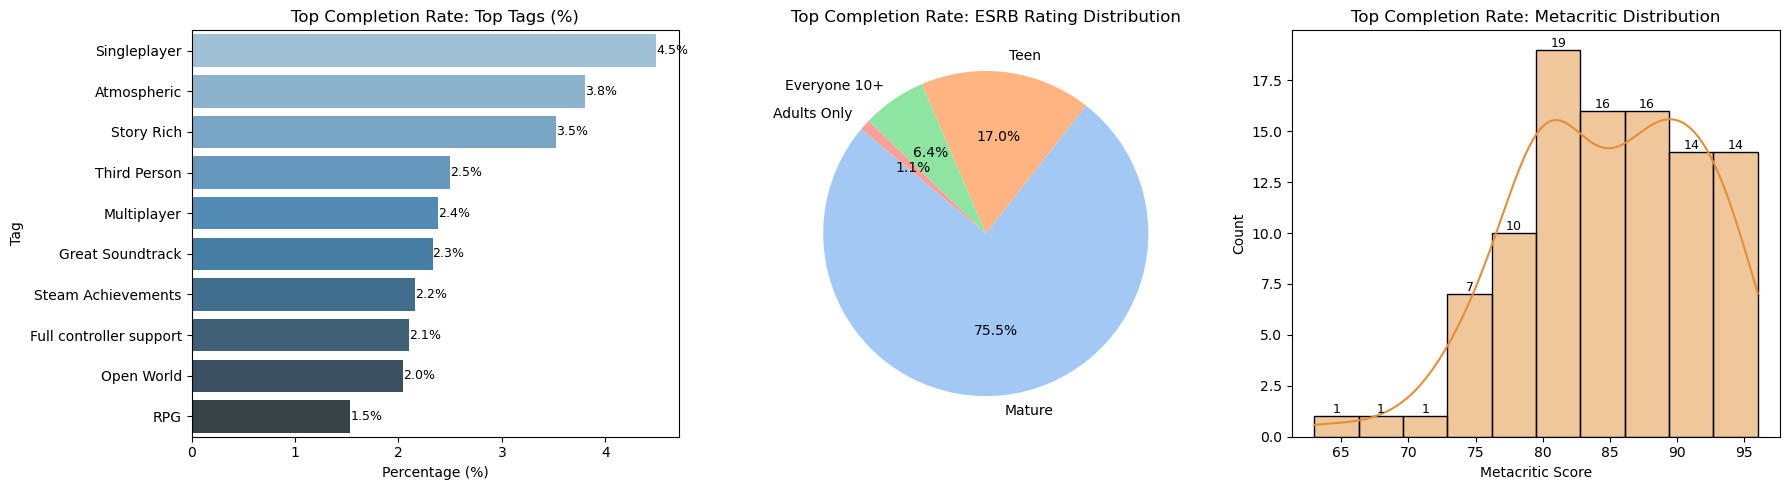

/var/folders/87/r431hq3n75l_7nlczx7tq_9c0000gn/T/ipykernel_7459/3381532208.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tag_df, y="Tag", x="Percentage", ax=axes[0], palette="Blues_d")


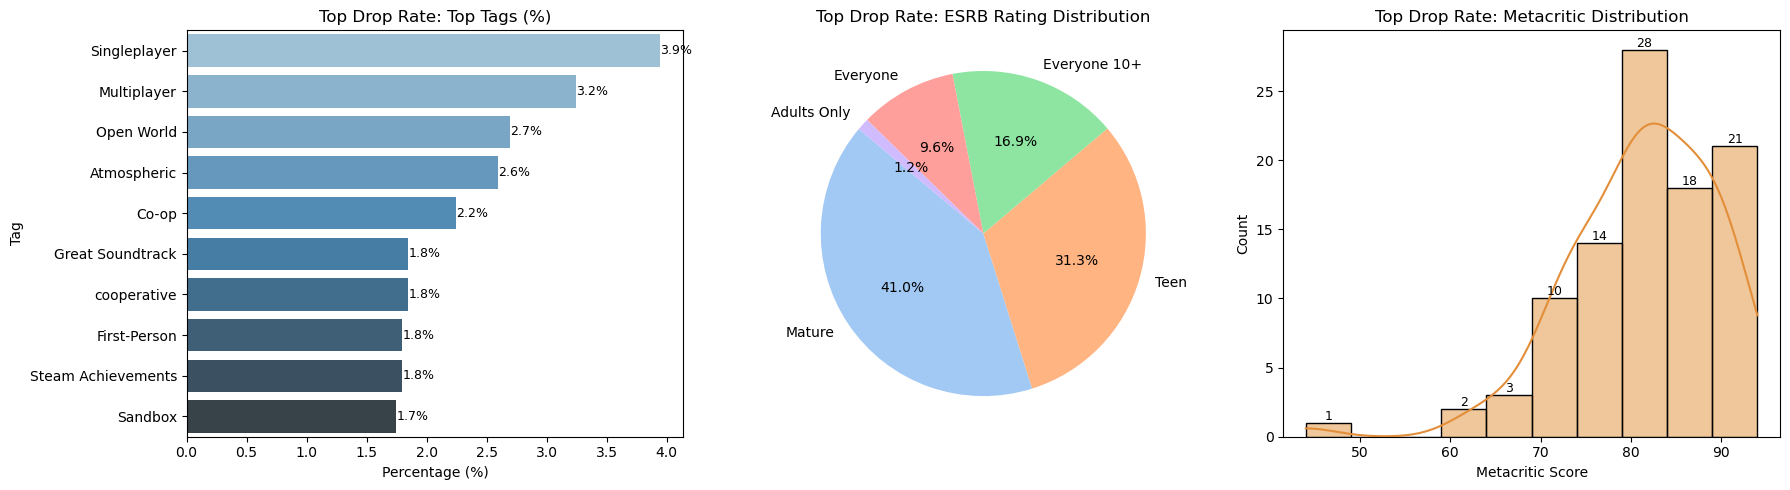

/var/folders/87/r431hq3n75l_7nlczx7tq_9c0000gn/T/ipykernel_7459/3381532208.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tag_df, y="Tag", x="Percentage", ax=axes[0], palette="Blues_d")


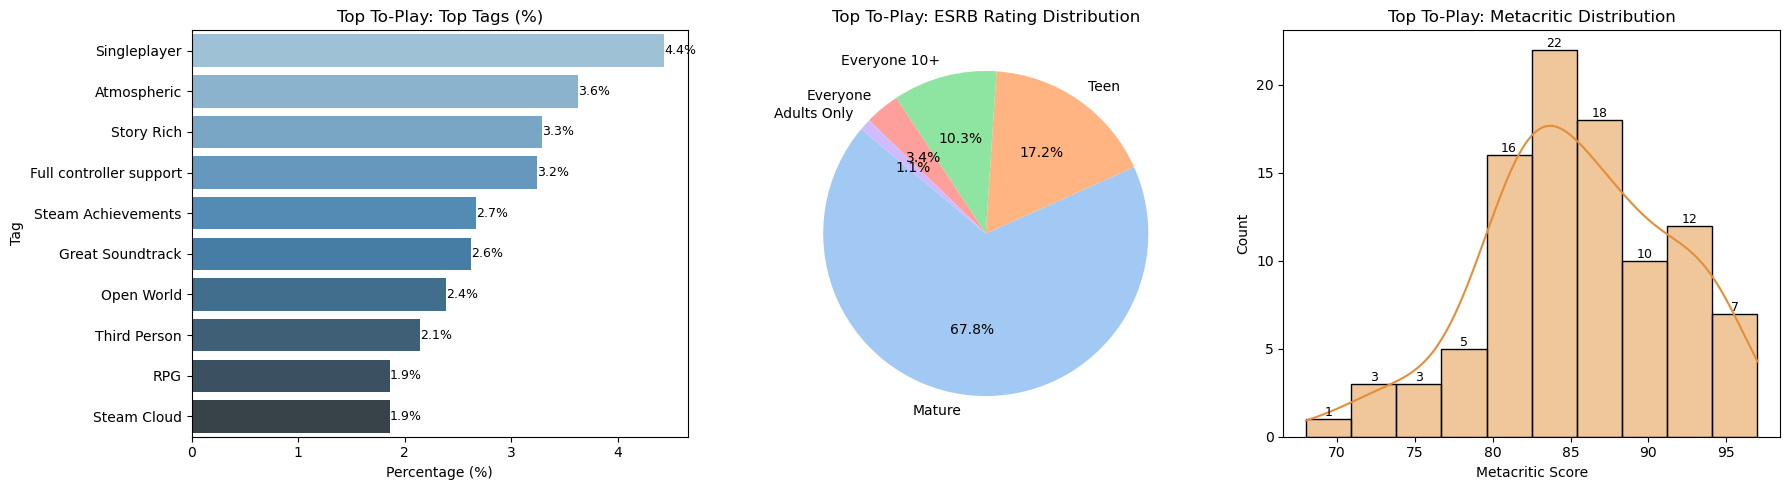

/var/folders/87/r431hq3n75l_7nlczx7tq_9c0000gn/T/ipykernel_7459/3381532208.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tag_df, y="Tag", x="Percentage", ax=axes[0], palette="Blues_d")


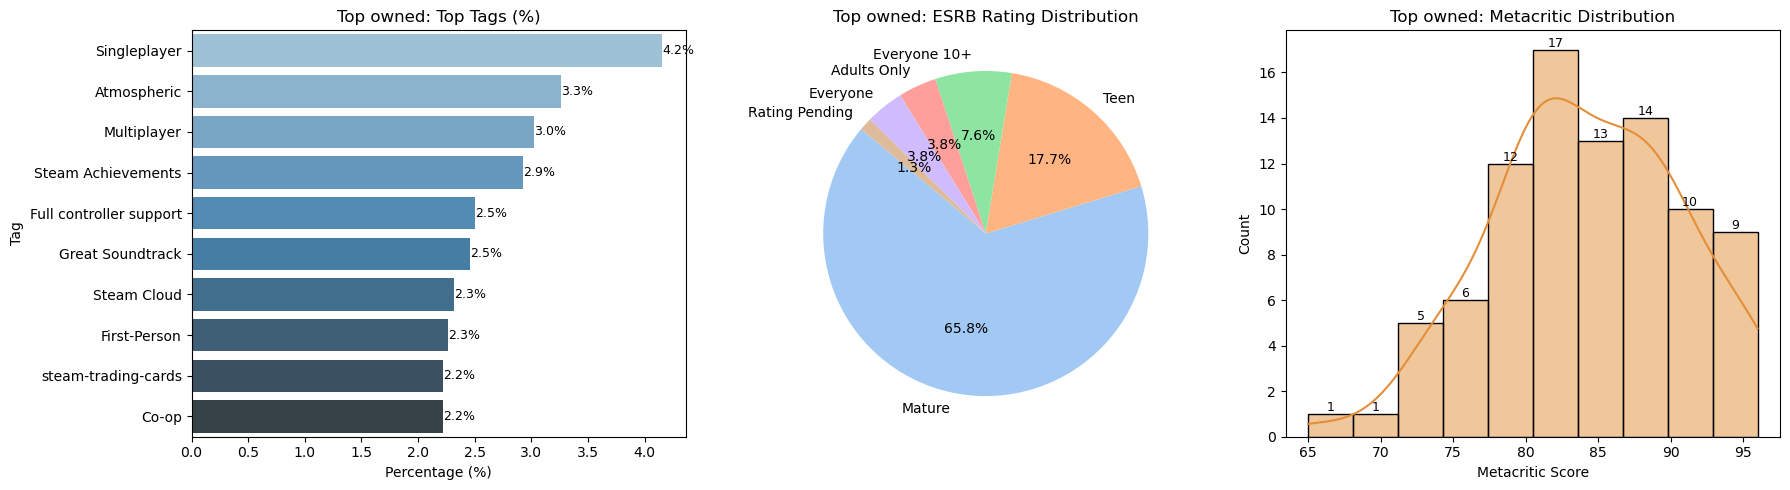

In [35]:

analyze_top_games(top100_cp, "Top Completion Rate")
analyze_top_games(top100_drop, "Top Drop Rate")
analyze_top_games(top100_toplay, "Top To-Play")
analyze_top_games(top100_own, "Top owned")


**Top Completion Rate** (Nhóm game có tỷ lệ hoàn thành cao nhất)
1. **Tag**

* **Singleplayer** đứng đầu (4.4%), cho thấy người chơi có xu hướng hoàn thành các trò chơi chơi đơn, có thể vì câu chuyện liền mạch và ít phân tâm.
* **Atmospheric**, **Story Rich**, và **Third Person** là các yếu tố thường gắn với trải nghiệm cá nhân, nhập vai, tạo động lực để hoàn thành.
* Tags thiên về **nội dung** và **trải nghiệm cá nhân** xuất hiện nhiều hơn là gameplay dạng co-op hay cạnh tranh.

2. **ESRB**

* Game gắn mác **Mature** chiếm áp đảo (73.5%) ⇒ người chơi trưởng thành có xu hướng kiên trì hoàn thành game hơn.

3. **Metacritic**

* Phân phối điểm **Metacritic** nghiêng về bên phải (85–95), nhiều game có điểm đánh giá cao ⇒ người chơi có xu hướng hoàn thành game chất lượng. 

---

**Top Drop Rate** (Nhóm game bị bỏ dở nhiều nhất)

1. **Tag**

* Tags như **Multiplayer**, **Open World**, **Sandbox**, **RPG** thường gắn với gameplay dài, cần cooperate, dễ gây mệt mỏi, chán nản cho 1 trong nhưgx người chơi
* **Steam Achievements** xuất hiện ⇒ có thể bị “grind” hóa, gây chán.

2. **ESRB**

* Game **Teen** (47.4%) và **Mature** (36.8%) chiếm đa số ⇒ độ tuổi người chơi không quyết định hoàn toàn việc drop game.


3. **Metacritic**

* Phân phối điểm Metacritic rộng hơn (65–95), vẫn tập trung khoảng 80–90.
* Nhiều game có **điểm đánh giá tốt** nhưng vẫn bị bỏ dở, cho thấy **Metacritic không phản ánh hoàn toàn khả năng giữ chân người chơi**.

---

**Top To-Play** (Game được thêm vào danh sách chơi sau)

1. **Tag**

* Lại thấy **Singleplayer**, **Atmospheric**, **Story Rich** thống trị ⇒ người chơi muốn trải nghiệm các game chất lượng, sâu sắc.
* **Full Controller Support** và **Great Soundtrack** xuất hiện sớm ⇒ người chơi có xu hướng “ưu tiên” các game được đánh giá tốt về mặt trải nghiệm.

2. **ESRB**

* **Mature** tiếp tục chiếm áp đảo (68.8%) ⇒ người chơi muốn thử game nghiêm túc, phức tạp hơn, nhưng chưa có thời gian hoặc quyết tâm chơi ngay.
* Nhóm này có sự tương đồng cao với completion group, nhưng mới chỉ dừng ở ý định.

3. **Metacritic**

* Phân phối điểm gần như chuẩn, đỉnh nằm ở khoảng 80–90 ⇒ người chơi ưu tiên game có đánh giá cao để chơi sau.
* Nhóm này **có tiềm năng cao để hoàn thành**, nếu được kích thích đúng lúc.


=> Người chơi có xu hướng hoàn thành các game có **trải nghiệm cá nhân sâu sắc, chất lượng cao**, và **dành cho người lớn**. Bên cạnh đó, điểm metacritic cũng phần nào đánh giá chính xác



In [36]:
df2 = df.copy(deep=True)
df2["added_by_status"] = df2["added_by_status"].apply(ast.literal_eval)
for key in ["yet", "owned", "beaten", "toplay", "dropped", "playing"]:
    #df2[key] = df2["added_by_status"].apply(lambda x: x.get(key, 0))
      df2['status_'+ key] = df2["added_by_status"].apply(lambda x: x.get(key, 0))
df2.drop(columns=["added_by_status"], inplace=True)
df2.head()

,name,description_raw,metacritic,playtime,tags,stores,esrb_rating,developers,publishers,updated,status_yet,status_owned,status_beaten,status_toplay,status_dropped,status_playing
0,Grand Theft Auto V,"Rockstar Games went bigger, since their previo...",92.0,74,"['Singleplayer', 'Steam Achievements', 'Multip...","['Steam', 'PlayStation Store', 'Epic Games', '...",Mature,"['Rockstar North', 'Rockstar Games']",['Rockstar Games'],2025-05-26T14:58:48,557,12702,6240,626,1154,752
1,The Witcher 3: Wild Hunt,"The third game in a series, it holds nothing b...",92.0,43,"['Singleplayer', 'Full controller support', 'A...","['GOG', 'PlayStation Store', 'Steam', 'Xbox St...",Mature,['CD PROJEKT RED'],['CD PROJEKT RED'],2025-05-25T18:05:53,1173,12701,5083,833,991,892
2,Portal 2,Portal 2 is a first-person puzzle game develop...,95.0,11,"['Singleplayer', 'Steam Achievements', 'Multip...","['Xbox Store', 'Steam', 'PlayStation Store', '...",Everyone 10+,['Valve Software'],"['Electronic Arts', 'Valve']",2025-05-26T14:58:22,657,13004,5711,397,626,161
3,Counter-Strike: Global Offensive,Counter-Strike is a multiplayer phenomenon in ...,81.0,64,"['Steam Achievements', 'Multiplayer', 'Full co...","['PlayStation Store', 'Steam', 'Xbox 360 Store']",Mature,"['Valve Software', 'Hidden Path Entertainment']",['Valve'],2025-05-26T16:11:35,268,14083,1105,79,2094,631
4,Tomb Raider (2013),A cinematic revival of the series in its actio...,86.0,10,"['Singleplayer', 'Multiplayer', 'Full controll...","['Xbox 360 Store', 'Steam', 'PlayStation Store...",Mature,['Crystal Dynamics'],['Square Enix'],2025-05-23T20:02:39,695,11542,4393,285,557,117


In [37]:
top100_highest_playtime = df1.nlargest(100, 'playtime')[['name', 'playtime', 'status_yet', 'status_owned', 'status_beaten', 'status_toplay', 'status_dropped', 'status_playing']]

In [38]:
# retrieve top 100 games with highest playtime
top_playtime_df = df.sort_values(by='playtime', ascending=False).dropna(subset=['playtime']).head(100)
top_playtime_df.head()

,name,description_raw,metacritic,playtime,tags,stores,esrb_rating,developers,publishers,updated,added_by_status
274,The Legend of Zelda: Breath of the Wild,The Legend of Zelda: Breath of the Wild is an ...,97.0,121,"['RPG', 'Open World', 'Sandbox', 'Action-Adven...",['Nintendo Store'],Everyone 10+,['Nintendo'],['Nintendo'],2025-05-25T08:14:28,"{'yet': 359, 'owned': 1464, 'beaten': 2313, 't..."
432,Persona 5,Persona series is a part of Japanese franchise...,93.0,105,"['Singleplayer', 'Atmospheric', 'RPG', 'Explor...",['PlayStation Store'],Mature,['Atlus'],"['Deep Silver', 'Buka Entertainment', 'Atlus']",2025-05-11T23:18:35,"{'yet': 320, 'owned': 2502, 'beaten': 929, 'to..."
0,Grand Theft Auto V,"Rockstar Games went bigger, since their previo...",92.0,74,"['Singleplayer', 'Steam Achievements', 'Multip...","['Steam', 'PlayStation Store', 'Epic Games', '...",Mature,"['Rockstar North', 'Rockstar Games']",['Rockstar Games'],2025-05-26T14:58:48,"{'yet': 557, 'owned': 12702, 'beaten': 6240, '..."
3,Counter-Strike: Global Offensive,Counter-Strike is a multiplayer phenomenon in ...,81.0,64,"['Steam Achievements', 'Multiplayer', 'Full co...","['PlayStation Store', 'Steam', 'Xbox 360 Store']",Mature,"['Valve Software', 'Hidden Path Entertainment']",['Valve'],2025-05-26T16:11:35,"{'yet': 268, 'owned': 14083, 'beaten': 1105, '..."
157,Elden Ring,"The Golden Order has been broken.\n\nRise, Tar...",95.0,62,"['Singleplayer', 'Steam Achievements', 'Multip...","['Steam', 'PlayStation Store', 'Xbox Store']",Mature,['FromSoftware'],"['Bandai Namco Entertainment', 'FromSoftware']",2025-05-25T02:39:23,"{'yet': 399, 'owned': 4699, 'beaten': 1017, 't..."


/var/folders/87/r431hq3n75l_7nlczx7tq_9c0000gn/T/ipykernel_7459/3381532208.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tag_df, y="Tag", x="Percentage", ax=axes[0], palette="Blues_d")


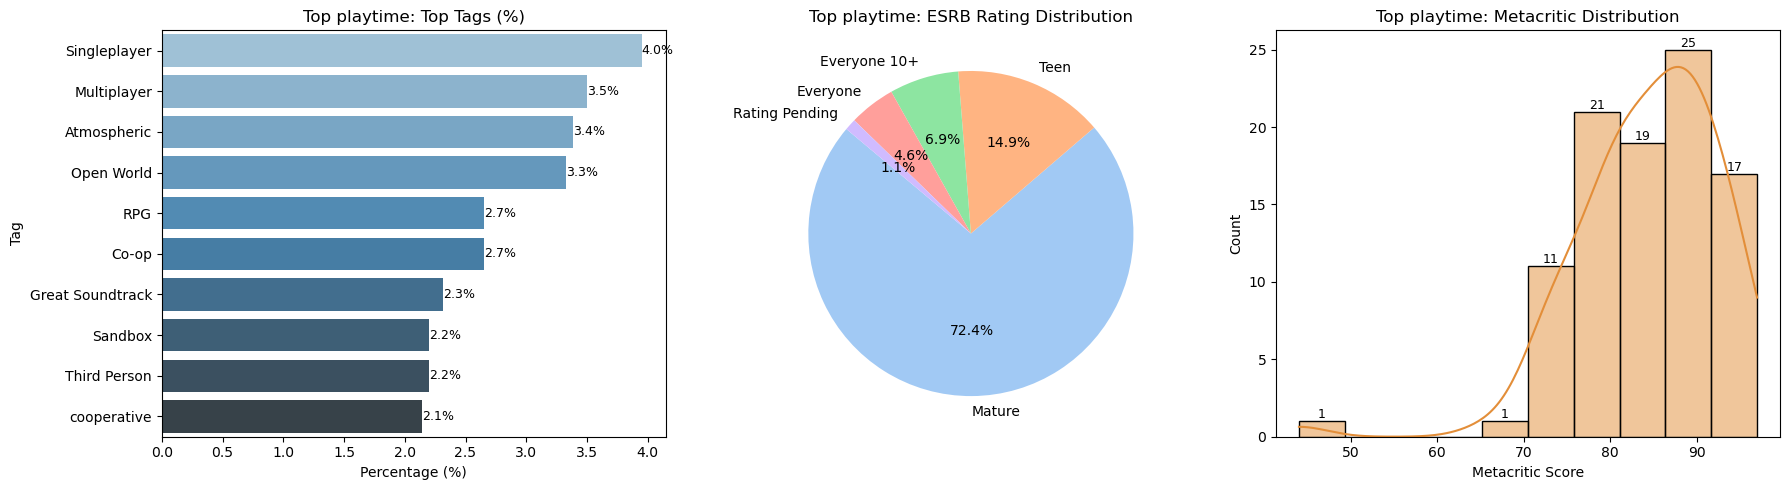

In [39]:
analyze_top_games(top_playtime_df, "Top playtime")

**1. Phân Bố Tag Phổ Biến (Top Tags)**
- Các tag phổ biến nhất:
  - **Singleplayer**: 4.0%
  - **Multiplayer**: 3.5%
  - **Atmospheric**, **Open World**, **RPG**: từ 2.7% đến 3.4%
- Cùng xuất hiện cả Singleplayer và Multiplayer cho thấy một số game kết hợp được cả hai chế độ.

=> Các game có thời gian chơi cao thường mang yếu tố: **Thế giới mở**, **Trải nghiệm nhập vai sâu**, **Bầu không khí cảm xúc cao**. Điều này cho thấy tính nhập vai và chiều sâu nội dung là chìa khóa giữ chân người chơi lâu dài.

---

**2. ESRB Rating Distribution**

- Phân loại **Mature** chiếm đa số: **72.4%**
- Teen: 14.9%
- Everyone 10+: 6.9%
- Các mức khác: rất ít (<5%)

=> Game được dán nhãn dành cho người lớn có nội dung phong phú, sâu sắc hoặc mang tính bạo lực — đây là yếu tố thu hút nhóm người chơi trung thành, chơi trong thời gian dài.


---

**3. Phân Phối Điểm Metacritic**

- Điểm số chủ yếu nằm trong khoảng **70–90**
- Cao nhất: khoảng **25 game đạt 85–90 điểm**
- Dưới 50 điểm: gần như không có

=> Game có playtime cao thường được đánh giá chất lượng tốt từ cả người chơi và chuyên gia. Điểm số cao thể hiện khả năng thiết kế game cuốn hút, đáng chơi lâu dài.

### 2. Phân tích Description Raw

In [40]:
df.head()

,name,description_raw,metacritic,playtime,tags,stores,esrb_rating,developers,publishers,updated,added_by_status
0,Grand Theft Auto V,"Rockstar Games went bigger, since their previo...",92.0,74,"['Singleplayer', 'Steam Achievements', 'Multip...","['Steam', 'PlayStation Store', 'Epic Games', '...",Mature,"['Rockstar North', 'Rockstar Games']",['Rockstar Games'],2025-05-26T14:58:48,"{'yet': 557, 'owned': 12702, 'beaten': 6240, '..."
1,The Witcher 3: Wild Hunt,"The third game in a series, it holds nothing b...",92.0,43,"['Singleplayer', 'Full controller support', 'A...","['GOG', 'PlayStation Store', 'Steam', 'Xbox St...",Mature,['CD PROJEKT RED'],['CD PROJEKT RED'],2025-05-25T18:05:53,"{'yet': 1173, 'owned': 12701, 'beaten': 5083, ..."
2,Portal 2,Portal 2 is a first-person puzzle game develop...,95.0,11,"['Singleplayer', 'Steam Achievements', 'Multip...","['Xbox Store', 'Steam', 'PlayStation Store', '...",Everyone 10+,['Valve Software'],"['Electronic Arts', 'Valve']",2025-05-26T14:58:22,"{'yet': 657, 'owned': 13004, 'beaten': 5711, '..."
3,Counter-Strike: Global Offensive,Counter-Strike is a multiplayer phenomenon in ...,81.0,64,"['Steam Achievements', 'Multiplayer', 'Full co...","['PlayStation Store', 'Steam', 'Xbox 360 Store']",Mature,"['Valve Software', 'Hidden Path Entertainment']",['Valve'],2025-05-26T16:11:35,"{'yet': 268, 'owned': 14083, 'beaten': 1105, '..."
4,Tomb Raider (2013),A cinematic revival of the series in its actio...,86.0,10,"['Singleplayer', 'Multiplayer', 'Full controll...","['Xbox 360 Store', 'Steam', 'PlayStation Store...",Mature,['Crystal Dynamics'],['Square Enix'],2025-05-23T20:02:39,"{'yet': 695, 'owned': 11542, 'beaten': 4393, '..."


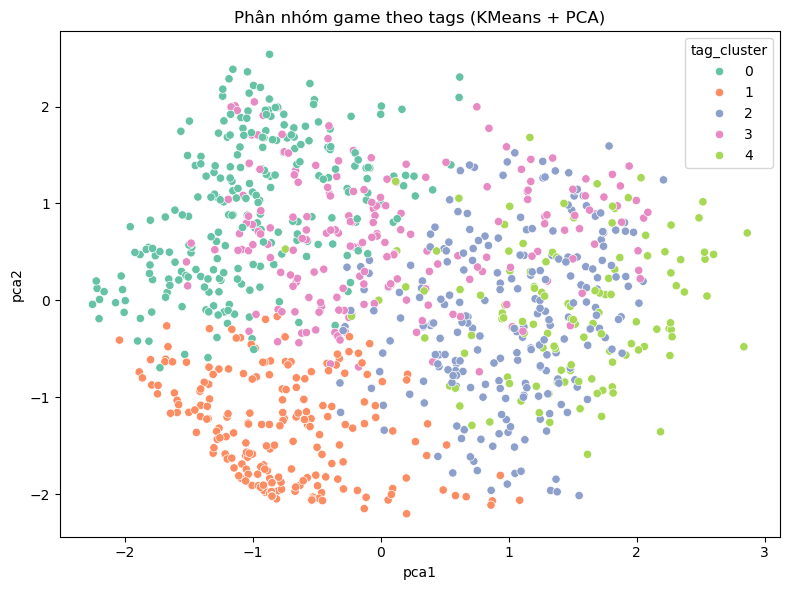

In [41]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import ast

# Tạo tag string
df["tags_str"] = df["tags"].dropna().apply(lambda x: " ".join(ast.literal_eval(x)))

# Vector hóa
vectorizer = CountVectorizer(max_features=100, binary=True)
X = vectorizer.fit_transform(df["tags_str"].fillna("")).toarray()

# KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
df["tag_cluster"] = kmeans.fit_predict(X)

# PCA để giảm chiều và vẽ
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)
df["pca1"] = X_reduced[:, 0]
df["pca2"] = X_reduced[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="pca1", y="pca2", hue="tag_cluster", palette="Set2")
plt.title("Phân nhóm game theo tags (KMeans + PCA)")
plt.tight_layout()
plt.show()


In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# TF-IDF
tfidf = TfidfVectorizer(max_df=0.95, min_df=5, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df["description_raw"].fillna(""))

# LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf_matrix)

# In top words mỗi topic
feature_names = tfidf.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    print(f"Topic {topic_idx + 1}: {' | '.join(top_words)}")


Topic 1: stunts | visceral | sprint | cooperation | meter | corporate | scenario | circuits | chaotic | economy
Topic 2: batman | arkham | joker | gotham | asylum | egyptian | poison | skies | videogame | captures
Topic 3: game | player | world | players | new | story | character | time | characters | gameplay
Topic 4: dirt | rally | racing | grid | career | championships | circuits | drivers | routes | cars
Topic 5: game | players | new | player | war | multiplayer | series | campaign | weapons | missions


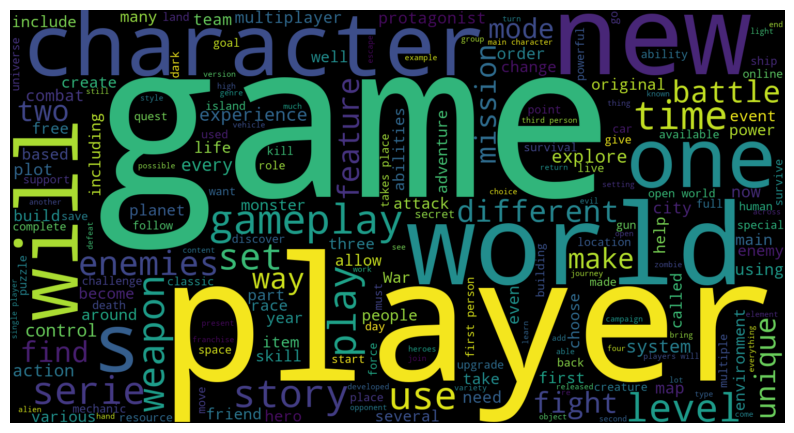

In [43]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Tập stopwords
stop_words = set(STOPWORDS)

# Ghép tất cả các mô tả thành một chuỗi dài
sentences = df['description_raw'].fillna('').astype(str).str.cat(sep=' ')

# Tạo WordCloud
wordcloud = WordCloud(
    width=1500,
    height=800,
    background_color='black',
    stopwords=stop_words,
    min_font_size=15
).generate(sentences)

# Hiển thị WordCloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


Những từ xuất hiện nhiều nhất là topic words, như game, player, character,... 

In [44]:

from bertopic import BERTopic

texts = df["description_raw"].fillna("").tolist()
topic_model = BERTopic(language="english", verbose=True)
topics, _ = topic_model.fit_transform(texts)

# Hiển thị top chủ đề
topic_model.get_topic_info().head()
topic_model.visualize_topics()


2025-06-04 18:05:27,445 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-06-04 18:05:57,268 - BERTopic - Embedding - Completed ✓
2025-06-04 18:05:57,269 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-04 18:06:03,189 - BERTopic - Dimensionality - Completed ✓
2025-06-04 18:06:03,190 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-04 18:06:03,240 - BERTopic - Cluster - Completed ✓
2025-06-04 18:06:03,248 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-04 18:06:03,401 - BERTopic - Representation - Completed ✓



**Intertopic Distance Map** – một biểu đồ cốt lõi trong mô hình BERTopic, được tạo ra nhờ thuật toán dimensionality reduction (giảm chiều dữ liệu), thường là UMAP hoặc t-SNE. Nó trực quan hóa khoảng cách ngữ nghĩa giữa các chủ đề (topics) mà mô hình phát hiện được.
Biểu đồ cho thấy:
- Các topics bố ra sao trong không gian embedding 2D. Topics càng xa nhau trên bản đồ, chủ đề đó càng khác biệt về nội dung. Topics gần nhau hoặc chồng lên, có thể đang nói về những thứ tương tự, hoặc cần hợp nhất (merge topics) nếu trùng lặp.
- Khoảng cách giữa các topics (gần nhau → liên quan về ngữ nghĩa).
- Kích thước bubble biểu thị số lượng văn bản trong mỗi chủ đề.




### 3. Model dự đoán Game bị drop hay sẽ được complete

##### 3.1 Label bằng package có sẵn
Crawl về thời gian trung bình cần phải bỏ ra để phá đảo game, và sủ dụng logic sau:
Nếu 1 game có số thời gian trung bình được chơi nhiều hơn hoặc bằng 80% thời gian estimated để beaten game, game đó sẽ được label là complete


In [45]:
from howlongtobeatpy import HowLongToBeat


In [71]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [46]:
hltb = HowLongToBeat()
def fetch_estimated_time(title):
    try:
        results = hltb.search(title)
        if results:
            best = max(results, key=lambda x: x.similarity)
            return best.main_story  # Hoặc main_extra, tùy mục tiêu
    except:
        return None

df1["estimated_time"] = df1["name"].apply(fetch_estimated_time)


In [ ]:
# # Copy và giữ đúng các cột cần
# columns_to_keep = [
#     'name', 'description_raw', 'metacritic', 'playtime', 'tags', 'stores', 'esrb_rating',
#     'developers', 'publishers', 'updated',
#     'status_yet', 'status_owned', 'status_beaten', 'status_toplay',
#     'status_dropped', 'status_playing',
#     'completion_rate', 'drop_rate', 'play_rate', 'estimated_time'
# ]

# df1 = df1[columns_to_keep].copy()


In [78]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1003 entries, 0 to 1033
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             1003 non-null   object 
 1   description_raw  1001 non-null   object 
 2   metacritic       873 non-null    float64
 3   playtime         1003 non-null   int64  
 4   tags             1003 non-null   object 
 5   stores           1003 non-null   object 
 6   esrb_rating      1003 non-null   object 
 7   developers       1003 non-null   object 
 8   publishers       1003 non-null   object 
 9   updated          1003 non-null   object 
 10  status_yet       1003 non-null   int64  
 11  status_owned     1003 non-null   int64  
 12  status_beaten    1003 non-null   int64  
 13  status_toplay    1003 non-null   int64  
 14  status_dropped   1003 non-null   int64  
 15  status_playing   1003 non-null   int64  
 16  completion_rate  1003 non-null   float64
 17  drop_rate        10

In [89]:
# 1. Giữ lại game có estimated_time
df1 = df1[df1["estimated_time"].notna()].copy()

# 2. Tạo label: complete vs dropped
df1["label"] = df1.apply(
    lambda x: "complete" if x["playtime"] >= 0.8 * x["estimated_time"] 
              else "dropped", axis=1
)

df1.shape

(930, 21)

In [93]:
# split features and target
X = df1.drop(columns=[
    "name", "description_raw", "stores", "publishers", "developers", 
    "updated", "completion_rate", "drop_rate", "play_rate", "label"
])
y = df1["label"]

# split train test 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train labels distribution:\n{y_train.value_counts(normalize=True)}")


Train shape: (744, 11), Test shape: (186, 11)
Train labels distribution:
label
dropped     0.771505
complete    0.228495
Name: proportion, dtype: float64


In [ ]:
# ----- Encode esrb_rating -----
for df_ in [X_train, X_test]:
    df_["esrb_rating"] = df_["esrb_rating"].fillna("unknown")

esrb_dummies_train = pd.get_dummies(X_train["esrb_rating"], prefix="esrb")
esrb_dummies_test = pd.get_dummies(X_test["esrb_rating"], prefix="esrb")

X_train.drop(columns=["esrb_rating"], inplace=True)
X_test.drop(columns=["esrb_rating"], inplace=True)

X_train = pd.concat([X_train, esrb_dummies_train], axis=1)
X_test = pd.concat([X_test, esrb_dummies_test], axis=1)

# Align để tránh thiếu cột trong test
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# ----- Encode tags -----
mlb = MultiLabelBinarizer()
mlb.fit(df1["tags"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else []))

for df_, name in zip([X_train, X_test], ["train", "test"]):
    tags = df_["tags"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
    tags_encoded = mlb.transform(tags)
    tags_df = pd.DataFrame(tags_encoded, columns=mlb.classes_, index=df_.index)
    df_.drop(columns=["tags"], inplace=True)
    df_ = pd.concat([df_, tags_df], axis=1)
    
    if name == "train":
        X_train = df_
    else:
        X_test = df_


In [97]:
# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [105]:
from lazypredict.Supervised import LazyClassifier

In [110]:
clf = LazyClassifier(random_state=42)

# Ensure X and y are defined (from cell 13)
# Fit the LazyClassifier and evaluate
models, predictions = clf.fit(X_train_scaled, X_test_scaled, y_train, y_test)

# Display the performance of the models
models

  0%|          | 0/31 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 574, number of negative: 170
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2019
[LightGBM] [Info] Number of data points in the train set: 744, number of used features: 147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.771505 -> initscore=1.216831
[LightGBM] [Info] Start training from score 1.216831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.97,0.96,None,0.97,0.32
AdaBoostClassifier,0.97,0.95,None,0.97,0.38
DecisionTreeClassifier,0.95,0.92,None,0.95,0.04
BaggingClassifier,0.94,0.90,None,0.94,0.13
NearestCentroid,0.75,0.66,None,0.75,0.05
PassiveAggressiveClassifier,0.72,0.65,None,0.73,0.16
RandomForestClassifier,0.82,0.65,None,0.79,0.31
LinearSVC,0.68,0.64,None,0.70,0.93
SGDClassifier,0.78,0.63,None,0.76,0.06


##### 3.2 Label bằng drop rate và completion rate

In [130]:
df2 = pd.read_csv("rawg_games_1000.csv")

# Xử lý df2 tương tự như df2
df2 = df2.drop(df[df['playtime'] == 0].index)
df2["added_by_status"] = df2["added_by_status"].apply(ast.literal_eval)
for key in ["yet", "owned", "beaten", "toplay", "dropped", "playing"]:
    #df2[key] = df2["added_by_status"].apply(lambda x: x.get(key, 0))
      df2['status_'+ key] = df2["added_by_status"].apply(lambda x: x.get(key, 0))
df2.drop(columns=["added_by_status"], inplace=True)
# drop illogical records
df2[
      (df2['status_owned'] < df2['status_beaten']) |
      (df2['status_owned'] < df2['status_dropped']) |
      (df2['status_owned'] < df2['status_playing'])
]
df2 = df2.drop(
      df2[
      (df2['status_owned'] < df2['status_beaten']) |
      (df2['status_owned'] < df2['status_dropped']) |
      (df2['status_owned'] < df2['status_playing'])
].index
)
# Tính tỷ lệ
df2["completion_rate"] = df2["status_beaten"] / df2["status_owned"]
df2["drop_rate"] = df2["status_dropped"] / df2["status_owned"]
df2["play_rate"] = df2["status_playing"] / df2["status_owned"]
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1023 entries, 0 to 1033
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             1023 non-null   object 
 1   description_raw  1021 non-null   object 
 2   metacritic       889 non-null    float64
 3   playtime         1023 non-null   int64  
 4   tags             1023 non-null   object 
 5   stores           1023 non-null   object 
 6   esrb_rating      747 non-null    object 
 7   developers       1023 non-null   object 
 8   publishers       1023 non-null   object 
 9   updated          1023 non-null   object 
 10  status_yet       1023 non-null   int64  
 11  status_owned     1023 non-null   int64  
 12  status_beaten    1023 non-null   int64  
 13  status_toplay    1023 non-null   int64  
 14  status_dropped   1023 non-null   int64  
 15  status_playing   1023 non-null   int64  
 16  completion_rate  1023 non-null   float64
 17  drop_rate        10

In [131]:
# Add target col
df2['label'] = df2.apply(lambda x: 'complete' if x['completion_rate'] > x['drop_rate'] else 'dropped', axis=1)

Nếu game có drop rate cao hơn completion rate, game đó sẽ được label drop, và ngược lại

In [132]:
temp =df2[[df2["label"] == "complete"] and df2['completion_rate'] < df2['drop_rate']]
temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 346 entries, 3 to 1033
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             346 non-null    object 
 1   description_raw  344 non-null    object 
 2   metacritic       267 non-null    float64
 3   playtime         346 non-null    int64  
 4   tags             346 non-null    object 
 5   stores           346 non-null    object 
 6   esrb_rating      196 non-null    object 
 7   developers       346 non-null    object 
 8   publishers       346 non-null    object 
 9   updated          346 non-null    object 
 10  status_yet       346 non-null    int64  
 11  status_owned     346 non-null    int64  
 12  status_beaten    346 non-null    int64  
 13  status_toplay    346 non-null    int64  
 14  status_dropped   346 non-null    int64  
 15  status_playing   346 non-null    int64  
 16  completion_rate  346 non-null    float64
 17  drop_rate        346

Có 346 records được ghi nhận có conflict với logic sử dụng estimated time, những game này có thời gian chơi trung bình cao, tuy nhiên lại được label drop. Những game này thường có cốt truyện dài, khó hoặc là game thể loại co-op, cần sụ phối hợp cho nên vẫn bị label drop

In [133]:
# split features and target
X = df2.drop(columns=[
    "name", "description_raw", "stores", "publishers", "developers", 
    "updated", "completion_rate", "drop_rate", "play_rate", "label"
])
y = df2["label"]

# split train test 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train labels distribution:\n{y_train.value_counts(normalize=True)}")


Train shape: (818, 10), Test shape: (205, 10)
Train labels distribution:
label
complete   0.66
dropped    0.34
Name: proportion, dtype: float64


In [134]:
# ----- Encode esrb_rating -----
for df_ in [X_train, X_test]:
    df_["esrb_rating"] = df_["esrb_rating"].fillna("unknown")

esrb_dummies_train = pd.get_dummies(X_train["esrb_rating"], prefix="esrb")
esrb_dummies_test = pd.get_dummies(X_test["esrb_rating"], prefix="esrb")

X_train.drop(columns=["esrb_rating"], inplace=True)
X_test.drop(columns=["esrb_rating"], inplace=True)

X_train = pd.concat([X_train, esrb_dummies_train], axis=1)
X_test = pd.concat([X_test, esrb_dummies_test], axis=1)

# Align để tránh thiếu cột trong test
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# ----- Encode tags -----
mlb = MultiLabelBinarizer()
mlb.fit(df1["tags"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else []))

for df_, name in zip([X_train, X_test], ["train", "test"]):
    tags = df_["tags"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
    tags_encoded = mlb.transform(tags)
    tags_df = pd.DataFrame(tags_encoded, columns=mlb.classes_, index=df_.index)
    df_.drop(columns=["tags"], inplace=True)
    df_ = pd.concat([df_, tags_df], axis=1)
    
    if name == "train":
        X_train = df_
    else:
        X_test = df_

In [135]:
# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [136]:
clf = LazyClassifier(random_state=42)

# Ensure X and y are defined (from cell 13)
# Fit the LazyClassifier and evaluate
models, predictions = clf.fit(X_train_scaled, X_test_scaled, y_train, y_test)

# Display the performance of the models
models

  0%|          | 0/31 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 277, number of negative: 541
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1857
[LightGBM] [Info] Number of data points in the train set: 818, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.338631 -> initscore=-0.669402
[LightGBM] [Info] Start training from score -0.669402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.98,0.96,None,0.98,0.85
AdaBoostClassifier,0.96,0.95,None,0.96,0.36
BaggingClassifier,0.94,0.93,None,0.94,0.14
DecisionTreeClassifier,0.92,0.91,None,0.92,0.10
RandomForestClassifier,0.87,0.87,None,0.87,0.27
BernoulliNB,0.82,0.84,None,0.83,0.05
ExtraTreesClassifier,0.84,0.83,None,0.84,0.25
NearestCentroid,0.81,0.83,None,0.82,0.08
LogisticRegression,0.81,0.81,None,0.81,0.13


Kết quả tốt hơn một chút so với việc label bằng estimated_time, điều này là dự đoán được, bởi như đã phân tích, có nhiều games (~30%) có thời gian chơi trung bình chơi tương đối lới nhưng vẫn có thể bị drop. Vì vậy, label bằng drop_rate, completion_rate như tính toán trên có vẻ hợp lí hơn.